In [7]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# Imports
import numpy as np
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.INFO)

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

In [10]:
get_available_gpus()

['/device:GPU:0']

In [11]:
def cnn_model_fn(features, labels, mode):
  """Model function for CNN."""
  # Input Layer
  input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

  # Convolutional Layer #1
  conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

  # Pooling Layer #1
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

  # Convolutional Layer #2 and Pooling Layer #2
  conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

  # Dense Layer
  pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
  dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
  dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

  # Logits Layer
  logits = tf.layers.dense(inputs=dropout, units=10)

  predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
  }

  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

  # Calculate Loss (for both TRAIN and EVAL modes)
  loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

  # Configure the Training Op (for TRAIN mode)
  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    train_op = optimizer.minimize(
        loss=loss,
        global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  # Add evaluation metrics (for EVAL mode)
  eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
  return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [12]:
# Load training and eval data
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
train_data = mnist.train.images # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
eval_data = mnist.test.images # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

Instructions for updating:
Use the retry module or similar alternatives.
Instructions for updating:
Please use tf.data.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [13]:
train_data.shape

(55000, 784)

In [14]:
train_labels.shape

(55000,)

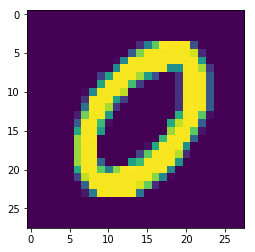

In [15]:
tmp = train_data[15].reshape(28,28)
plt.imshow(tmp)

In [16]:
# Create the Estimator
mnist_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="/tmp/mnist_convnet_model")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_keep_checkpoint_max': 5, '_service': None, '_num_ps_replicas': 0, '_task_id': 0, '_num_worker_replicas': 1, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_evaluation_master': '', '_log_step_count_steps': 100, '_global_id_in_cluster': 0, '_save_summary_steps': 100, '_model_dir': '/tmp/mnist_convnet_model', '_is_chief': True, '_master': '', '_keep_checkpoint_every_n_hours': 10000, '_task_type': 'worker', '_tf_random_seed': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001F66DAE0A90>}


In [17]:
# Set up logging for predictions
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
  tensors=tensors_to_log, every_n_iter=50)

In [ ]:
# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=train_labels,
    batch_size=100,
    num_epochs=None,
    shuffle=True)
mnist_classifier.train(
    input_fn=train_input_fn,
    steps=20000,
    hooks=[logging_hook])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/mnist_convnet_model\model.ckpt-20000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 20001 into /tmp/mnist_convnet_model\model.ckpt.
INFO:tensorflow:probabilities = [[0.00100641 0.00025063 0.00016665 0.00002381 0.00003819 0.9830872
  0.00118425 0.00231737 0.01191309 0.00001256]
 [0.00000306 0.99924904 0.00013231 0.00002921 0.00000514 0.00000434
  0.00000407 0.00022504 0.00033992 0.00000781]
 [0.00004618 0.00000112 0.00000135 0.00001214 0.00022716 0.0014637
  0.00000741 0.9886572  0.00000348 0.00958021]
 [0.9429445  0.00007916 0.01498203 0.03391072 0.000002   0.00689079
  0.00000853 0.00034957 0.00021749 0.00061507]
 [0.999495   0.00000006 0.00002293 0.00000095 0.00000319 0.00003541
  0.00015818 0.00001285 0.00000473

INFO:tensorflow:loss = 0.17492148, step = 20000
INFO:tensorflow:probabilities = [[0.00010207 0.00090611 0.00010288 0.0003146  0.00020328 0.00703964
  0.0000013  0.9284524  0.00010417 0.06277354]
 [0.00046831 0.00066265 0.00850685 0.00004059 0.430182   0.00011855
  0.5551681  0.00044368 0.00174617 0.00266307]
 [0.00000736 0.00000369 0.00013263 0.00000155 0.9916161  0.00000244
  0.00819309 0.00000268 0.00002328 0.00001706]
 [0.00044093 0.98408645 0.00100864 0.0020965  0.00076912 0.0030404
  0.0001991  0.00394387 0.00370411 0.00071081]
 [0.00001593 0.00000132 0.00031665 0.00026214 0.00000123 0.00161869
  0.00000067 0.0000406  0.9975151  0.00022769]
 [0.00071255 0.00000087 0.00014593 0.0000143  0.00000036 0.00423555
  0.00012051 0.00000141 0.9947173  0.00005127]
 [0.00003643 0.99736905 0.00068652 0.00004801 0.00005364 0.00000163
  0.00033537 0.00009981 0.00135057 0.0000189 ]
 [0.0000025  0.00044726 0.00169003 0.9700927  0.00009082 0.00027568
  0.00000117 0.00027871 0.024821   0.00230012]
 

INFO:tensorflow:global_step/sec: 113.852
INFO:tensorflow:probabilities = [[0.69229084 0.00115417 0.01451883 0.00204483 0.04261902 0.0211432
  0.05340235 0.01077779 0.01835158 0.14369741]
 [0.00000006 0.00000006 0.00000081 0.99984837 0.00000001 0.00001969
  0.         0.00000004 0.00011586 0.00001518]
 [0.00001513 0.00000498 0.00009045 0.00000119 0.00075485 0.00001285
  0.9988765  0.0000001  0.00024071 0.00000315]
 [0.00112625 0.00139069 0.00654066 0.00025311 0.00231675 0.01419439
  0.9684548  0.00000782 0.00568692 0.00002861]
 [0.00000971 0.00005758 0.00036422 0.00028886 0.0010953  0.00010734
  0.9976253  0.00000053 0.00045096 0.00000029]
 [0.00000141 0.00000068 0.00000097 0.00001875 0.00000045 0.9989742
  0.00007254 0.00000006 0.00090204 0.00002885]
 [0.0000188  0.99221706 0.00180244 0.0005823  0.00008544 0.00000651
  0.00006974 0.00028111 0.00483483 0.00010155]
 [0.00015189 0.00000356 0.00026721 0.9989004  0.00000174 0.00027689
  0.00000015 0.00000007 0.00034462 0.00005346]
 [0.00020

INFO:tensorflow:loss = 0.100076914, step = 20100 (0.880 sec)
INFO:tensorflow:probabilities = [[0.00001092 0.00000358 0.00000027 0.00004489 0.00063104 0.00006436
  0.00000003 0.9479615  0.00000393 0.05127941]
 [0.00015212 0.00001137 0.00008091 0.00039795 0.00009111 0.00023479
  0.00000296 0.00000295 0.9850433  0.01398249]
 [0.00000151 0.00000321 0.00000014 0.00011514 0.02745706 0.00035784
  0.00000032 0.00683719 0.00005079 0.96517676]
 [0.00192153 0.00092715 0.00173713 0.00229761 0.08163426 0.00227239
  0.00036717 0.0047199  0.03081725 0.8733056 ]
 [0.00013209 0.00142577 0.0005861  0.00009197 0.00001083 0.00031409
  0.9955433  0.00000017 0.00189498 0.00000078]
 [0.00000013 0.00000032 0.00000388 0.00000415 0.9956494  0.00000018
  0.00000159 0.00000938 0.00000111 0.00432994]
 [0.00010445 0.00002211 0.99510986 0.00137764 0.         0.00000021
  0.00000079 0.00000005 0.00338473 0.00000008]
 [0.03382288 0.00711278 0.1859821  0.75310326 0.00005371 0.01630668
  0.00303338 0.00006523 0.0003043 

INFO:tensorflow:global_step/sec: 133.871
INFO:tensorflow:probabilities = [[0.9562857  0.00000068 0.00002732 0.00051258 0.00100977 0.00559036
  0.00018811 0.0003636  0.00060184 0.0354201 ]
 [0.00000001 0.00000003 0.00000004 0.00000026 0.9999261  0.00000059
  0.00000266 0.00000052 0.00000049 0.00006943]
 [0.00008129 0.00000146 0.0003081  0.00066211 0.0019771  0.00005955
  0.00000296 0.01386722 0.00400798 0.9790323 ]
 [0.0001204  0.13282628 0.01874825 0.12267082 0.01105297 0.00142955
  0.00166824 0.68394995 0.01271887 0.01481468]
 [0.9994431  0.00000032 0.00006099 0.00001411 0.00000984 0.00001719
  0.00015523 0.000002   0.00029136 0.00000586]
 [0.00035598 0.00178447 0.46495858 0.00260549 0.4320256  0.00049242
  0.00346691 0.00012328 0.08126634 0.01292092]
 [0.         0.00000004 0.00000029 0.00000019 0.9998042  0.00000232
  0.00001767 0.00000275 0.00006137 0.00011116]
 [0.00301853 0.00004224 0.00870656 0.00002403 0.0314971  0.0000593
  0.94551116 0.00029642 0.01074414 0.00010057]
 [0.9352

INFO:tensorflow:loss = 0.19934487, step = 20200 (0.745 sec)
INFO:tensorflow:probabilities = [[0.83544236 0.00025101 0.11304165 0.02542136 0.00067454 0.00186627
  0.00034278 0.00774747 0.0050116  0.010201  ]
 [0.9993987  0.00000001 0.00009279 0.0000028  0.00000004 0.00048309
  0.00001994 0.0000001  0.00000071 0.00000185]
 [0.00023002 0.9028577  0.01048486 0.03214405 0.0004483  0.00002005
  0.00004243 0.05164887 0.00144487 0.00067885]
 [0.00130967 0.00001512 0.0002606  0.00132882 0.00006308 0.00272257
  0.00035299 0.00000043 0.9938684  0.00007834]
 [0.99089843 0.0000004  0.00042904 0.0000004  0.00074218 0.00033683
  0.00715834 0.00007644 0.00000856 0.00034966]
 [0.00000591 0.99914634 0.00011317 0.00033234 0.00001417 0.00002604
  0.00002692 0.00006809 0.00023898 0.00002802]
 [0.00035534 0.00037667 0.00022916 0.01814512 0.00026467 0.00865944
  0.00011152 0.00012517 0.9661166  0.00561624]
 [0.00000243 0.00090384 0.00005848 0.00045779 0.81333005 0.00079215
  0.00005313 0.00146979 0.00757785 

INFO:tensorflow:global_step/sec: 130.987
INFO:tensorflow:probabilities = [[0.00000965 0.98737943 0.00084653 0.00567509 0.00024801 0.00019784
  0.00002728 0.0016134  0.00285532 0.00114741]
 [0.00000006 0.00000004 0.00000635 0.00004592 0.00000004 0.00000001
  0.         0.9997781  0.00000044 0.00016904]
 [0.00000287 0.9991592  0.00005039 0.00004718 0.00000233 0.00000428
  0.00004093 0.0000115  0.00067463 0.00000655]
 [0.00065702 0.00000128 0.00107856 0.00000538 0.01460443 0.00007548
  0.98323774 0.00000054 0.00004033 0.00029922]
 [0.9997198  0.         0.0000833  0.00000003 0.00000125 0.00000272
  0.00019205 0.00000004 0.00000032 0.00000051]
 [0.00000155 0.00000018 0.00000158 0.00000116 0.0000042  0.00001855
  0.         0.99960846 0.00000547 0.00035896]
 [0.00009476 0.9894888  0.00070664 0.00174392 0.00016204 0.00021656
  0.00052261 0.00027817 0.00643518 0.00035128]
 [0.98683524 0.00000269 0.00028786 0.00001835 0.00003128 0.00122878
  0.00903272 0.00001043 0.00180749 0.00074501]
 [0.997

INFO:tensorflow:loss = 0.13811742, step = 20300 (0.765 sec)
INFO:tensorflow:probabilities = [[0.00000195 0.00000182 0.00001249 0.00086469 0.00000785 0.9980914
  0.00000342 0.00000069 0.00022608 0.00078953]
 [0.00000825 0.00000007 0.0000019  0.00007116 0.00001265 0.00003139
  0.         0.9864217  0.00000078 0.01345217]
 [0.00000148 0.00000762 0.00001864 0.00019806 0.9694457  0.00003882
  0.00004063 0.00090046 0.00058094 0.02876755]
 [0.00003722 0.00000022 0.00000104 0.00004292 0.00000892 0.99889094
  0.00000115 0.00000004 0.00048059 0.00053702]
 [0.00000109 0.00027745 0.00005159 0.0120059  0.01933183 0.00095229
  0.00001096 0.00276694 0.01311841 0.95148355]
 [0.04703625 0.00205643 0.00421192 0.01576325 0.0006704  0.18300259
  0.01041037 0.00002562 0.7354694  0.00135377]
 [0.00225997 0.0000626  0.00023411 0.00426625 0.0000001  0.99228776
  0.00006162 0.00009948 0.00070321 0.00002485]
 [0.00000114 0.00000814 0.0001577  0.00009708 0.98707724 0.00003431
  0.00002832 0.00002962 0.00010762 0

INFO:tensorflow:global_step/sec: 133.692
INFO:tensorflow:probabilities = [[0.01932389 0.00003952 0.00390821 0.0003805  0.05214133 0.00043643
  0.00301325 0.00291195 0.03092699 0.8869179 ]
 [0.00012705 0.01428679 0.00319437 0.02651562 0.0832592  0.03505566
  0.00019672 0.00818998 0.0882432  0.7409314 ]
 [0.00240244 0.00009879 0.00261688 0.00258582 0.00008031 0.98565024
  0.00334481 0.0000311  0.00303703 0.00015252]
 [0.00033027 0.00002352 0.0002858  0.00000357 0.00060723 0.00156235
  0.99709857 0.0000009  0.00005714 0.0000306 ]
 [0.00000077 0.         0.0000012  0.00007306 0.00000003 0.9999043
  0.00000008 0.00000016 0.00000627 0.0000141 ]
 [0.00030724 0.96983767 0.00748938 0.00378575 0.0009885  0.00173079
  0.00326048 0.00362807 0.00739248 0.00157988]
 [0.00000365 0.00005166 0.01568051 0.00004059 0.03675237 0.00014991
  0.947152   0.00006278 0.00007238 0.00003411]
 [0.00007514 0.00028238 0.97096395 0.0013899  0.00000659 0.00004587
  0.02522351 0.         0.00201263 0.00000001]
 [0.0000

INFO:tensorflow:loss = 0.19229169, step = 20400 (0.749 sec)
INFO:tensorflow:probabilities = [[0.00000051 0.         0.00000108 0.00001068 0.         0.00000448
  0.         0.9998242  0.00000013 0.00015883]
 [0.00000066 0.47574523 0.521562   0.00063524 0.00000022 0.00004199
  0.00000384 0.000062   0.00194692 0.00000189]
 [0.00000666 0.9980982  0.00049806 0.00019974 0.00032696 0.00001269
  0.00021951 0.00038716 0.00017917 0.00007172]
 [0.00000476 0.00000029 0.00005896 0.0000003  0.00018157 0.00007194
  0.9996793  0.         0.00000274 0.00000013]
 [0.000001   0.00000012 0.0001289  0.99313134 0.00000001 0.00204349
  0.         0.00000015 0.00395917 0.00073583]
 [0.50628924 0.00022895 0.37288517 0.10245091 0.0000426  0.00069124
  0.00125372 0.00001452 0.0158407  0.00030295]
 [0.9994691  0.00000008 0.00026859 0.0000014  0.0000002  0.00013732
  0.00001904 0.00000796 0.00007298 0.00002307]
 [0.00000001 0.0000053  0.00001553 0.0000005  0.99978334 0.00000011
  0.00001307 0.00006486 0.00008256 

INFO:tensorflow:global_step/sec: 134.49
INFO:tensorflow:probabilities = [[0.00000003 0.0000003  0.00001813 0.99996924 0.         0.00000446
  0.         0.00000002 0.00000771 0.00000007]
 [0.0018832  0.00124105 0.00100365 0.05838506 0.00020278 0.00098355
  0.0001153  0.00026672 0.91554135 0.02037741]
 [0.00027475 0.00011029 0.9988133  0.00072602 0.00000247 0.00000123
  0.00000014 0.00000496 0.00006475 0.00000197]
 [0.01318796 0.00003081 0.97804594 0.00155379 0.00029924 0.000342
  0.00009211 0.00272865 0.00026706 0.00345247]
 [0.00056556 0.00752066 0.00001917 0.00181647 0.03681823 0.00190241
  0.00001645 0.13389343 0.0003524  0.8170953 ]
 [0.00005777 0.00000106 0.00158112 0.00000273 0.0006009  0.00012134
  0.9975127  0.00000007 0.00009807 0.00002412]
 [0.0000302  0.00000342 0.00000053 0.00000258 0.00000325 0.9996791
  0.00008401 0.00001357 0.00018238 0.00000111]
 [0.00002389 0.0000126  0.00002762 0.00000216 0.00002306 0.0059297
  0.9922577  0.00000002 0.00172299 0.00000038]
 [0.00012464

INFO:tensorflow:loss = 0.102689646, step = 20500 (0.742 sec)
INFO:tensorflow:probabilities = [[0.00010831 0.07017852 0.0006623  0.00483658 0.025258   0.01274273
  0.00031899 0.00302608 0.8649792  0.01788928]
 [0.99363965 0.00000031 0.00041885 0.00001976 0.00000302 0.00001041
  0.00000744 0.0004173  0.00503771 0.0004454 ]
 [0.00000023 0.00000021 0.00001135 0.00000014 0.9999418  0.00000126
  0.00003205 0.00000415 0.00000265 0.00000614]
 [0.99916995 0.00000018 0.00009695 0.00000847 0.00000033 0.00032385
  0.00001406 0.00000398 0.00037523 0.00000715]
 [0.9735493  0.00000183 0.00026892 0.0001983  0.00000656 0.00001978
  0.00000058 0.01363136 0.00000538 0.01231793]
 [0.00000016 0.00011535 0.00025346 0.0019432  0.00000101 0.00001472
  0.         0.9973008  0.00002533 0.00034592]
 [0.00000171 0.00000527 0.00000349 0.9993119  0.00000074 0.00061752
  0.00000009 0.00000062 0.00003016 0.0000285 ]
 [0.00000004 0.00000081 0.00016097 0.9997383  0.         0.00000855
  0.         0.00000035 0.00008555

INFO:tensorflow:global_step/sec: 136.821
INFO:tensorflow:probabilities = [[0.0000018  0.00000071 0.00000351 0.00001444 0.996121   0.00000342
  0.00000422 0.00013684 0.00009506 0.00361887]
 [0.00053434 0.00009196 0.05233076 0.00454743 0.00000256 0.00001906
  0.00000013 0.9348752  0.00478668 0.00281192]
 [0.00000056 0.0000236  0.99003065 0.0010077  0.00101896 0.00011546
  0.000311   0.00741605 0.0000698  0.00000624]
 [0.00882701 0.00000225 0.00016356 0.00002345 0.00000008 0.9903369
  0.00043456 0.00002411 0.00018738 0.00000074]
 [0.00011207 0.9809786  0.00059762 0.00623505 0.00166108 0.00244601
  0.00142377 0.00026036 0.0057556  0.00053002]
 [0.00001274 0.01270372 0.00491853 0.00571932 0.00000513 0.00000294
  0.00000003 0.9741426  0.00221016 0.00028491]
 [0.00000006 0.00000983 0.9968946  0.00309352 0.         0.00000006
  0.         0.000002   0.00000001 0.        ]
 [0.00000004 0.00000007 0.00000436 0.000012   0.00000001 0.00000097
  0.         0.99994385 0.00000042 0.00003834]
 [0.0000

INFO:tensorflow:loss = 0.13696478, step = 20600 (0.732 sec)
INFO:tensorflow:probabilities = [[0.00000297 0.0000852  0.00000974 0.00115331 0.00243814 0.00061422
  0.00000021 0.00569738 0.00114542 0.98885345]
 [0.00001482 0.00009973 0.0003717  0.99855703 0.00000009 0.00007763
  0.00000044 0.00000173 0.00086506 0.00001168]
 [0.00004108 0.97136295 0.00042704 0.00122473 0.001833   0.0001843
  0.00004712 0.01977008 0.00449948 0.00061007]
 [0.00005423 0.00014302 0.00138704 0.99345124 0.00000499 0.00448279
  0.00006143 0.00000036 0.00038994 0.00002492]
 [0.00000211 0.00004651 0.00002651 0.00000419 0.00004266 0.00000689
  0.9998293  0.00000011 0.00004168 0.00000002]
 [0.00000565 0.00000035 0.00000387 0.00000141 0.00004476 0.0000048
  0.         0.98757786 0.00000246 0.01235878]
 [0.00000069 0.0000002  0.0000021  0.00000003 0.00003153 0.00009365
  0.99985564 0.         0.00001603 0.00000008]
 [0.00000176 0.0002854  0.9911874  0.00495636 0.000024   0.00000543
  0.0000303  0.00296719 0.00053734 0.

INFO:tensorflow:global_step/sec: 131.881
INFO:tensorflow:probabilities = [[0.0032713  0.00054725 0.00223211 0.00018158 0.95313597 0.0001633
  0.00179915 0.00079964 0.00094006 0.03692971]
 [0.00007046 0.00000405 0.00010192 0.0000018  0.00019687 0.00011704
  0.9995012  0.00000006 0.00000623 0.00000049]
 [0.00000926 0.00015565 0.0002003  0.00000355 0.00020894 0.00009449
  0.9992397  0.00000006 0.0000874  0.00000063]
 [0.00018861 0.00000029 0.00001137 0.00141883 0.00088324 0.00006714
  0.00000288 0.00950396 0.00099128 0.98693246]
 [0.00000845 0.00004159 0.00000329 0.00100502 0.5473413  0.00056545
  0.00008257 0.00026151 0.00016489 0.45052597]
 [0.00001649 0.9931912  0.00017241 0.00092045 0.00024695 0.00012913
  0.00001747 0.00075594 0.00442223 0.00012764]
 [0.00009116 0.0000007  0.00018197 0.00000085 0.00021746 0.00003051
  0.9994635  0.00000024 0.00001325 0.00000031]
 [0.00004146 0.0000382  0.00003159 0.00000269 0.00011011 0.00030419
  0.99935967 0.00000002 0.00011141 0.00000072]
 [0.0000

INFO:tensorflow:loss = 0.14983834, step = 20700 (0.757 sec)
INFO:tensorflow:probabilities = [[0.00002069 0.00008605 0.00021948 0.00001301 0.99757177 0.00007667
  0.00060432 0.00024196 0.00023455 0.00093141]
 [0.00004926 0.00000057 0.00009307 0.00035491 0.00006663 0.00018483
  0.00015551 0.00000116 0.977821   0.02127308]
 [0.00047901 0.04327088 0.00480889 0.00529274 0.00367695 0.00464474
  0.0004047  0.00007586 0.7399563  0.1973899 ]
 [0.00042478 0.01596659 0.00897299 0.9715145  0.00000249 0.00073211
  0.00000089 0.00100965 0.00084253 0.00053346]
 [0.00000341 0.00000002 0.00004146 0.00000009 0.99979216 0.00000034
  0.00010495 0.0000321  0.00000751 0.000018  ]
 [0.00022481 0.00014118 0.00001242 0.00014321 0.0000081  0.99859947
  0.00009523 0.00003858 0.00072503 0.00001191]
 [0.00028119 0.99173474 0.00056316 0.00031167 0.0009246  0.00017757
  0.00206323 0.00199503 0.00182276 0.00012615]
 [0.00014526 0.98597413 0.00017927 0.00023455 0.00011516 0.001516
  0.00152493 0.00055221 0.00960433 0.

INFO:tensorflow:global_step/sec: 135.872
INFO:tensorflow:probabilities = [[0.00015345 0.00000015 0.00000028 0.00000043 0.00000658 0.000045
  0.00000001 0.99863666 0.0000001  0.00115729]
 [0.00003354 0.00115746 0.00120782 0.01128863 0.87917817 0.00480568
  0.00050099 0.01241295 0.0031256  0.08628916]
 [0.00008622 0.00041862 0.00278003 0.00066631 0.00004339 0.0016897
  0.9938361  0.00005912 0.00040987 0.0000105 ]
 [0.00001498 0.00005745 0.00000875 0.9979044  0.0000166  0.00050686
  0.00000022 0.0000119  0.00002945 0.00144923]
 [0.00114175 0.00000139 0.00007713 0.00023992 0.00000154 0.00001191
  0.00000819 0.00000802 0.9978497  0.00066039]
 [0.00007903 0.00000365 0.00108764 0.99581933 0.00000044 0.00027096
  0.00000022 0.00000809 0.00214982 0.00058056]
 [0.00000064 0.00000304 0.99569845 0.00053681 0.00000015 0.00000011
  0.00000007 0.00375644 0.00000424 0.00000005]
 [0.00046745 0.02503724 0.01159886 0.00293522 0.00021222 0.00088185
  0.00015675 0.00006961 0.95835423 0.00028658]
 [0.000019

INFO:tensorflow:loss = 0.20566015, step = 20800 (0.737 sec)
INFO:tensorflow:probabilities = [[0.00000025 0.0000003  0.00000159 0.00000088 0.00000011 0.00000176
  0.         0.9997348  0.0000014  0.00025887]
 [0.00001593 0.00011712 0.00023943 0.00001983 0.9969777  0.0000185
  0.0018854  0.00051197 0.00001316 0.00020081]
 [0.00000014 0.00011507 0.99780875 0.00030043 0.00002771 0.00011963
  0.00006652 0.00155273 0.00000476 0.00000418]
 [0.00000051 0.00000002 0.0000065  0.00000072 0.00000004 0.00000049
  0.         0.9999738  0.00000088 0.0000171 ]
 [0.00081441 0.         0.00000011 0.00000049 0.00000152 0.00001319
  0.         0.9985868  0.00000069 0.00058285]
 [0.00004926 0.00003457 0.00007333 0.00011439 0.00000174 0.0010717
  0.00037495 0.00000022 0.99827445 0.00000541]
 [0.00045231 0.00004711 0.15500216 0.00010504 0.047954   0.00034114
  0.79435873 0.00157763 0.00015967 0.0000022 ]
 [0.00112055 0.01188343 0.0019053  0.00832877 0.00048102 0.7763688
  0.00156599 0.00123244 0.19152203 0.0

INFO:tensorflow:global_step/sec: 131.44
INFO:tensorflow:probabilities = [[0.00000073 0.99852705 0.00002142 0.00061137 0.00020704 0.00001132
  0.00000758 0.00014683 0.0002561  0.0002105 ]
 [0.9997702  0.00000019 0.00006301 0.00000166 0.00000011 0.00002
  0.00014145 0.00000002 0.00000235 0.00000078]
 [0.00003282 0.00001522 0.00015001 0.00015858 0.00000284 0.00013386
  0.         0.97105116 0.00001797 0.02843756]
 [0.00003336 0.00001928 0.00001274 0.03195398 0.00000052 0.94310373
  0.00000007 0.00826148 0.01119853 0.00541628]
 [0.00000164 0.00000016 0.00000166 0.00000582 0.00232378 0.00000067
  0.00000006 0.00020884 0.00003022 0.99742717]
 [0.00001417 0.9987483  0.00009254 0.00002618 0.00009401 0.00000556
  0.00030211 0.00001526 0.00069431 0.00000749]
 [0.00008597 0.00000183 0.00005433 0.8912212  0.00000294 0.10533534
  0.00000069 0.00000249 0.00095038 0.00234475]
 [0.00024041 0.0000027  0.00006739 0.00003337 0.0058436  0.0000483
  0.00000651 0.00135943 0.00089468 0.9915036 ]
 [0.000004  

INFO:tensorflow:loss = 0.1930813, step = 20900 (0.761 sec)
INFO:tensorflow:probabilities = [[0.00004834 0.00728306 0.00027525 0.00102842 0.00023116 0.00086651
  0.0000944  0.00011377 0.9883243  0.00173479]
 [0.00006899 0.00243881 0.98847723 0.00661099 0.00001182 0.00008799
  0.00023971 0.00000008 0.00206425 0.0000002 ]
 [0.00001053 0.00000258 0.00000626 0.00032014 0.00003337 0.99195087
  0.0038119  0.00000064 0.00378028 0.00008352]
 [0.0000159  0.00066366 0.00099382 0.0715375  0.02829546 0.00130286
  0.00005268 0.3625107  0.00392753 0.5306999 ]
 [0.00000021 0.         0.00000013 0.00000736 0.00000002 0.9999627
  0.00000034 0.00000004 0.00002141 0.00000779]
 [0.0018314  0.00050262 0.00036088 0.04362687 0.00004855 0.78962594
  0.00213853 0.00000055 0.16172703 0.00013751]
 [0.00035704 0.00000072 0.00000219 0.00161152 0.00000997 0.99777526
  0.00000323 0.00000578 0.00013401 0.00010011]
 [0.00000076 0.00000005 0.99946576 0.00050099 0.00000044 0.00000237
  0.0000001  0.00002413 0.00000236 0.

INFO:tensorflow:global_step/sec: 133.32
INFO:tensorflow:probabilities = [[0.00000757 0.00000011 0.00000011 0.00000665 0.00001069 0.00000919
  0.00000001 0.99545383 0.00000152 0.00451026]
 [0.00023988 0.00007243 0.00007105 0.00060978 0.07314781 0.00725052
  0.00002026 0.9030413  0.00002475 0.01552214]
 [0.00000136 0.         0.00000806 0.00007663 0.00000148 0.00000579
  0.00000001 0.00000413 0.9998481  0.00005441]
 [0.00000003 0.00000026 0.00001138 0.00004205 0.00000009 0.00000003
  0.         0.99989045 0.00000171 0.00005401]
 [0.00010545 0.00005527 0.9814089  0.00117047 0.00000027 0.00000786
  0.00000006 0.00036477 0.01681856 0.00006828]
 [0.00013525 0.00052095 0.00031204 0.9088777  0.00002874 0.08881614
  0.00002414 0.00000129 0.0006748  0.00060906]
 [0.00000187 0.00004368 0.00015104 0.9811989  0.00002815 0.01839689
  0.00000067 0.00000387 0.00015224 0.00002263]
 [0.2879948  0.00001441 0.03427352 0.00226849 0.00007464 0.06431793
  0.00055069 0.33271617 0.20157613 0.07621314]
 [0.7514

INFO:tensorflow:loss = 0.097636156, step = 21000 (0.750 sec)
INFO:tensorflow:probabilities = [[0.00000298 0.00033028 0.00000307 0.0009047  0.9594843  0.00154987
  0.00001494 0.01189188 0.00008446 0.02573356]
 [0.00001646 0.00000023 0.00000012 0.00005302 0.00000055 0.99721473
  0.0000045  0.00000066 0.00240521 0.00030448]
 [0.00041228 0.00000039 0.00003978 0.00259    0.00000193 0.01684547
  0.0000083  0.00001227 0.9768248  0.00326486]
 [0.00000001 0.00000001 0.9999616  0.00003517 0.00000127 0.0000009
  0.00000074 0.         0.00000018 0.00000016]
 [0.00014785 0.00578788 0.00142379 0.0271891  0.14877227 0.00699217
  0.00007748 0.00555659 0.01159083 0.792462  ]
 [0.00129698 0.00000709 0.00005041 0.00701733 0.00582561 0.00328916
  0.00000344 0.42685205 0.07507825 0.48057964]
 [0.00000921 0.00002065 0.00006438 0.93334097 0.0000431  0.06263929
  0.00000063 0.00000016 0.00284662 0.00103509]
 [0.00000009 0.00000131 0.99996626 0.00001798 0.00000043 0.00000208
  0.00000052 0.00000025 0.00001037 

INFO:tensorflow:global_step/sec: 123.461
INFO:tensorflow:probabilities = [[0.00003921 0.00005167 0.9352249  0.00014952 0.04979702 0.00050914
  0.01408602 0.00006484 0.00004553 0.00003223]
 [0.9718745  0.00002105 0.00033004 0.00561106 0.00000165 0.01614703
  0.00001024 0.00448962 0.000059   0.00145588]
 [0.0000017  0.00000384 0.00000037 0.00000083 0.00000226 0.9963246
  0.00004269 0.00003229 0.00358026 0.00001111]
 [0.00750255 0.00467317 0.04962756 0.00077487 0.8010716  0.00042477
  0.05953379 0.00099447 0.07381739 0.00157978]
 [0.00000795 0.0000453  0.00000735 0.3405961  0.00008349 0.01679146
  0.00000074 0.00017853 0.00801241 0.63427675]
 [0.9999759  0.         0.00000277 0.00000001 0.00000001 0.00001241
  0.0000076  0.00000124 0.00000001 0.00000015]
 [0.00000184 0.00000063 0.00000305 0.00000626 0.00010258 0.9932387
  0.00604154 0.00000026 0.00060385 0.00000133]
 [0.00050265 0.00072002 0.98549646 0.00293126 0.00000419 0.00013028
  0.00001804 0.00020062 0.00973345 0.00026296]
 [0.00000

INFO:tensorflow:loss = 0.10810987, step = 21100 (0.809 sec)
INFO:tensorflow:probabilities = [[0.000002   0.00000001 0.00000583 0.00002705 0.00001284 0.00000416
  0.00000003 0.00317292 0.00000713 0.996768  ]
 [0.00000839 0.00000494 0.00001516 0.00011088 0.00001557 0.9995732
  0.00002903 0.00000088 0.00022484 0.00001722]
 [0.00006836 0.00001035 0.00220083 0.00008487 0.00004082 0.00026099
  0.9973169  0.00000004 0.00001617 0.00000068]
 [0.00000047 0.00013902 0.00002318 0.9993818  0.00000014 0.00042993
  0.00000035 0.0000018  0.00001191 0.00001138]
 [0.00000024 0.00000031 0.00000242 0.00000152 0.99935097 0.00000018
  0.00000974 0.00002611 0.00002022 0.00058823]
 [0.00203316 0.00007977 0.6110357  0.23725347 0.00000014 0.0000373
  0.00000266 0.00002314 0.14949532 0.00003927]
 [0.00007319 0.00103854 0.07336789 0.14215319 0.00011811 0.7378317
  0.00260212 0.00000097 0.04259125 0.00022305]
 [0.00001776 0.01491607 0.00150452 0.01187211 0.00002348 0.00405975
  0.00000069 0.935248   0.00079428 0.0

INFO:tensorflow:global_step/sec: 132.005
INFO:tensorflow:probabilities = [[0.00000169 0.00160408 0.9936963  0.00450769 0.00000094 0.00000023
  0.00000056 0.0001874  0.00000095 0.00000008]
 [0.00000058 0.00000562 0.99762017 0.00237166 0.         0.00000008
  0.         0.00000079 0.0000011  0.00000004]
 [0.9997086  0.         0.00015812 0.0000017  0.00000088 0.00000583
  0.00001042 0.00000986 0.00002349 0.00008111]
 [0.00000889 0.00000496 0.00000031 0.00013858 0.09590057 0.01060737
  0.00000118 0.12189448 0.00018345 0.7712602 ]
 [0.00000063 0.00224902 0.00002991 0.00531399 0.23691073 0.00035807
  0.00000127 0.00140385 0.00794051 0.745792  ]
 [0.00000169 0.00000098 0.00003581 0.00175484 0.00000542 0.00053066
  0.00000117 0.00000117 0.997072   0.00059633]
 [0.0001595  0.9924017  0.0010305  0.00061274 0.00008392 0.00034519
  0.00098338 0.00001192 0.00432878 0.00004251]
 [0.00000989 0.98636556 0.00037999 0.00013371 0.00036847 0.00003314
  0.00036271 0.00029185 0.01198688 0.00006778]
 [0.000

INFO:tensorflow:loss = 0.06489113, step = 21200 (0.759 sec)
INFO:tensorflow:probabilities = [[0.019687   0.00003801 0.00008731 0.00737172 0.00007522 0.9291319
  0.00042277 0.00259858 0.00537823 0.03520933]
 [0.00000066 0.00001509 0.00007225 0.00414608 0.00000592 0.00003186
  0.00000021 0.00000162 0.9956649  0.00006151]
 [0.0000282  0.00054357 0.93263316 0.00007826 0.02013787 0.00119796
  0.04225603 0.00298871 0.00012861 0.00000757]
 [0.00000111 0.00000029 0.00035779 0.00528159 0.00000136 0.0000016
  0.         0.993948   0.00000709 0.00040119]
 [0.00035653 0.02557445 0.05100724 0.01476871 0.00015154 0.00020926
  0.00000609 0.89508754 0.00269335 0.01014532]
 [0.00075266 0.00001412 0.00006334 0.00291873 0.0000048  0.99435633
  0.00093874 0.00000005 0.00086469 0.00008651]
 [0.9999379  0.         0.00000261 0.00000001 0.00000005 0.00000104
  0.00005802 0.00000031 0.00000001 0.00000006]
 [0.00005583 0.00000521 0.00001994 0.00000133 0.00006082 0.00014756
  0.99970907 0.         0.00000026 0.

INFO:tensorflow:global_step/sec: 131.82
INFO:tensorflow:probabilities = [[0.0000276  0.00000042 0.0000176  0.000146   0.00000838 0.99930954
  0.000344   0.00000003 0.00014512 0.00000136]
 [0.00036405 0.00048092 0.8505945  0.01950363 0.00030888 0.00024222
  0.00021068 0.12771262 0.0003436  0.00023875]
 [0.00112118 0.00202606 0.00007194 0.00051224 0.00037416 0.00392098
  0.00042847 0.00021353 0.9906942  0.00063725]
 [0.00000861 0.00073067 0.00122737 0.99022734 0.00000042 0.00710625
  0.00000406 0.00000087 0.00069388 0.00000055]
 [0.00000899 0.0000157  0.0000097  0.00000946 0.00006507 0.0000236
  0.99965596 0.00000001 0.00021047 0.00000107]
 [0.00000046 0.00000004 0.00000002 0.00000238 0.00000006 0.9999813
  0.00000038 0.00000009 0.00001402 0.00000122]
 [0.9887782  0.00001931 0.00140536 0.00031733 0.00109195 0.00056675
  0.00086708 0.00412691 0.00061745 0.00220969]
 [0.0000003  0.00023913 0.00018981 0.00002355 0.00000135 0.00004927
  0.00000071 0.00001645 0.9994599  0.00001951]
 [0.000005

INFO:tensorflow:loss = 0.09412021, step = 21300 (0.759 sec)
INFO:tensorflow:probabilities = [[0.00000002 0.00000008 0.00000032 0.00000793 0.00000001 0.00000314
  0.         0.9998822  0.00000024 0.00010594]
 [0.00000412 0.00008013 0.00001006 0.00002674 0.995142   0.00003841
  0.00014371 0.00052147 0.00229102 0.00174246]
 [0.00000001 0.00000006 0.00000003 0.00000015 0.9998355  0.00000178
  0.00000011 0.0000001  0.00000059 0.00016163]
 [0.00312419 0.00097502 0.00440695 0.01004895 0.00046117 0.9587989
  0.00015369 0.00775567 0.00663414 0.00764129]
 [0.00005758 0.8088448  0.00015074 0.00090555 0.00010506 0.00001765
  0.00000548 0.1794119  0.00095135 0.00954976]
 [0.00000015 0.00000146 0.00003136 0.99995744 0.         0.00000206
  0.         0.00000312 0.00000335 0.00000108]
 [0.00022348 0.00447679 0.97714716 0.01759871 0.00000326 0.00008481
  0.00000109 0.00003744 0.00039531 0.00003203]
 [0.0000008  0.00000681 0.0000248  0.00015596 0.01823036 0.00000135
  0.00000045 0.07778244 0.00024991 0

INFO:tensorflow:global_step/sec: 133.981
INFO:tensorflow:probabilities = [[0.00000203 0.0003457  0.99415356 0.00495616 0.00047287 0.00001
  0.00001368 0.0000235  0.00002012 0.00000252]
 [0.00031079 0.02646388 0.02681543 0.9314188  0.00000364 0.00325854
  0.00004307 0.0000334  0.01153468 0.00011783]
 [0.00044945 0.00214716 0.0001957  0.07002429 0.00736111 0.91064364
  0.00190344 0.00009648 0.00090176 0.00627684]
 [0.00001256 0.99747485 0.00032694 0.00027931 0.00047637 0.00016921
  0.00010136 0.0004173  0.00060498 0.00013712]
 [0.00004071 0.00005616 0.00188027 0.98156    0.00000111 0.00794896
  0.00000048 0.00003979 0.00729422 0.00117838]
 [0.00000092 0.00000731 0.00015175 0.00000227 0.99723035 0.00000074
  0.00006114 0.00028687 0.00001723 0.0022415 ]
 [0.00050717 0.00054273 0.00001478 0.01199632 0.09659063 0.23576263
  0.00215647 0.0074453  0.00189291 0.6430911 ]
 [0.00023763 0.00000083 0.00050068 0.0000674  0.00032835 0.00258724
  0.00348016 0.00000003 0.99275535 0.00004235]
 [0.000014

INFO:tensorflow:loss = 0.094755724, step = 21400 (0.744 sec)
INFO:tensorflow:probabilities = [[0.00000375 0.00017369 0.00003119 0.0007059  0.00225743 0.0012212
  0.000001   0.00360031 0.00102705 0.9909785 ]
 [0.00294498 0.00001875 0.00001569 0.00443616 0.00001473 0.9841
  0.00064434 0.0000012  0.00765772 0.00016641]
 [0.00000345 0.00000288 0.00007568 0.00000829 0.9970694  0.00000386
  0.00015592 0.00008062 0.00025786 0.00234219]
 [0.00104934 0.0000014  0.00000276 0.00000238 0.00084007 0.00017506
  0.00000007 0.9543661  0.00000778 0.04355511]
 [0.01010703 0.00002633 0.02850106 0.09808345 0.00002176 0.00137682
  0.0000155  0.00049646 0.8197522  0.04161935]
 [0.00000392 0.00000089 0.00001297 0.00011405 0.00000045 0.00000498
  0.         0.9995314  0.00000525 0.00032615]
 [0.00000006 0.00000015 0.00000482 0.00019034 0.00000004 0.00000083
  0.         0.9997842  0.00000012 0.00001941]
 [0.00000009 0.00000099 0.00002704 0.00000905 0.00651724 0.00004305
  0.00000038 0.00006285 0.00050776 0.99

INFO:tensorflow:global_step/sec: 136.642
INFO:tensorflow:probabilities = [[0.9937516  0.00001013 0.00119212 0.00019165 0.00001657 0.0014203
  0.00007193 0.00312051 0.0000024  0.00022294]
 [0.00009822 0.97212255 0.00099906 0.00407309 0.00053966 0.00031727
  0.00015225 0.0134204  0.0034513  0.00482612]
 [0.00001764 0.9414204  0.00251005 0.02368517 0.00195924 0.00002163
  0.00000992 0.02727411 0.0015011  0.00160077]
 [0.00814892 0.00000878 0.00016816 0.00002656 0.00055117 0.0005689
  0.00001341 0.9176069  0.00023098 0.07267623]
 [0.00013148 0.0000396  0.00004397 0.00021311 0.00006817 0.0000544
  0.00000024 0.92201716 0.00050639 0.07692553]
 [0.00004239 0.9551059  0.00356789 0.00310379 0.00271268 0.0007941
  0.0014708  0.00078071 0.03199022 0.00043169]
 [0.00000165 0.00007201 0.9983943  0.00101943 0.00000125 0.00000033
  0.00002671 0.00000005 0.00048445 0.00000002]
 [0.99962735 0.00000037 0.00025133 0.00003563 0.00000265 0.00001295
  0.00000134 0.00004245 0.00000089 0.00002517]
 [0.0013017

INFO:tensorflow:loss = 0.1668146, step = 21500 (0.732 sec)
INFO:tensorflow:probabilities = [[0.00000987 0.00003014 0.00003365 0.9994966  0.00000014 0.00015316
  0.00000009 0.00000008 0.00027381 0.00000246]
 [0.9966461  0.00000007 0.00267127 0.00001238 0.00000133 0.00000914
  0.00003272 0.00000184 0.00026996 0.00035512]
 [0.00000393 0.00000063 0.00000735 0.00016479 0.00000057 0.00029486
  0.00000005 0.00018861 0.9993049  0.00003435]
 [0.00013666 0.00003708 0.00219037 0.00001004 0.00711888 0.00030526
  0.98885965 0.00000259 0.00119695 0.00014247]
 [0.0000063  0.         0.00000001 0.00000209 0.00000002 0.00005382
  0.         0.9969388  0.00000022 0.00299873]
 [0.00007498 0.00000115 0.00012613 0.00212237 0.00039797 0.00005956
  0.00000017 0.0141834  0.00042668 0.98260754]
 [0.00019046 0.00121495 0.00065622 0.9097166  0.00270363 0.01447437
  0.00005284 0.00058567 0.00201195 0.06839342]
 [0.00005162 0.00000446 0.00001696 0.00821153 0.00000005 0.99068844
  0.00000003 0.00000118 0.00068377 0

INFO:tensorflow:global_step/sec: 131.628
INFO:tensorflow:probabilities = [[0.00006333 0.00011669 0.00096072 0.0001885  0.99475807 0.00012682
  0.00199464 0.00004419 0.00025162 0.00149543]
 [0.00002084 0.00000021 0.00001959 0.00168949 0.00001229 0.00001763
  0.00000028 0.00000539 0.99815816 0.00007618]
 [0.00009597 0.00000186 0.00000573 0.00042957 0.00204014 0.0003489
  0.00000093 0.06357207 0.00023282 0.933272  ]
 [0.00000311 0.00000007 0.00000059 0.00000524 0.00000643 0.00000531
  0.         0.99732023 0.00006314 0.00259584]
 [0.99999154 0.         0.00000113 0.00000001 0.         0.00000618
  0.00000091 0.         0.00000007 0.00000009]
 [0.00000106 0.00000008 0.9999933  0.00000415 0.0000001  0.0000002
  0.00000009 0.00000081 0.00000002 0.00000001]
 [0.00001211 0.00000066 0.00007095 0.00002232 0.00002227 0.0000346
  0.00000022 0.99962497 0.00000181 0.0002101 ]
 [0.00088198 0.00021751 0.0580098  0.01732765 0.01082819 0.00479091
  0.09796621 0.00050111 0.62344515 0.18603157]
 [0.015874

INFO:tensorflow:loss = 0.11986897, step = 21600 (0.763 sec)
INFO:tensorflow:probabilities = [[0.0000024  0.00000009 0.99977607 0.00020987 0.00000024 0.00000015
  0.0000001  0.00000001 0.00000874 0.00000241]
 [0.00042821 0.00000469 0.00014862 0.00056207 0.87658775 0.00016012
  0.00002333 0.02618259 0.00003122 0.09587151]
 [0.00999044 0.0002962  0.06202832 0.89867276 0.0000015  0.0275736
  0.00001593 0.00014621 0.00118044 0.00009448]
 [0.00000118 0.00001572 0.9994429  0.00051562 0.00000307 0.00000545
  0.00000064 0.00000002 0.00001176 0.00000357]
 [0.00000175 0.0000824  0.99971694 0.00004158 0.0000305  0.00000448
  0.00011491 0.00000506 0.00000224 0.00000009]
 [0.00002257 0.00031583 0.00136419 0.00001989 0.9917001  0.00017944
  0.00545902 0.00045229 0.0003164  0.00017023]
 [0.00002984 0.00010334 0.00035504 0.9925579  0.0000113  0.00047716
  0.00000099 0.00009752 0.00307444 0.00329258]
 [0.00004595 0.01652776 0.9669417  0.01631749 0.00000003 0.00002485
  0.00000043 0.00004252 0.00009909 0

INFO:tensorflow:global_step/sec: 133.243
INFO:tensorflow:probabilities = [[0.00000046 0.00000379 0.00000574 0.00033952 0.00002127 0.9877558
  0.00000174 0.00000154 0.00741929 0.0044508 ]
 [0.00000283 0.00000426 0.00021995 0.00002102 0.0007586  0.00059871
  0.9672208  0.00000006 0.031135   0.00003874]
 [0.00344577 0.07456952 0.12407099 0.01037293 0.02735071 0.5288351
  0.03819093 0.00679832 0.18022837 0.00613732]
 [0.00001232 0.00003677 0.99735755 0.00134905 0.00010584 0.00000068
  0.00001158 0.00000001 0.00111703 0.00000918]
 [0.00000035 0.00000091 0.00003981 0.9998919  0.00000002 0.0000488
  0.00000001 0.         0.00001006 0.00000827]
 [0.00026791 0.00206332 0.0025237  0.9930351  0.00000182 0.0018717
  0.00000051 0.00003745 0.00009878 0.00009994]
 [0.         0.00000008 0.0000001  0.00000002 0.99997187 0.00000094
  0.00000044 0.00000139 0.00000097 0.0000241 ]
 [0.00027893 0.00001375 0.00093043 0.00003518 0.00077169 0.00013306
  0.9975497  0.00000099 0.00028475 0.00000149]
 [0.0000044

INFO:tensorflow:loss = 0.09792576, step = 21700 (0.747 sec)
INFO:tensorflow:probabilities = [[0.00000022 0.00000537 0.00016563 0.00030252 0.00000014 0.00000037
  0.         0.9994998  0.00000875 0.00001732]
 [0.00001239 0.00024166 0.00000985 0.00329758 0.00383127 0.00412353
  0.00000549 0.00474103 0.00577077 0.9779664 ]
 [0.00003835 0.00008873 0.00007668 0.0000125  0.00013701 0.00259595
  0.9958216  0.00000019 0.00121492 0.00001398]
 [0.0000294  0.99563557 0.00248675 0.00022265 0.00003574 0.00004048
  0.00023587 0.00044077 0.00071781 0.00015491]
 [0.2005514  0.00000922 0.3055083  0.02061366 0.00010504 0.00925433
  0.00173951 0.00011473 0.32424775 0.13785599]
 [0.00016102 0.00000219 0.00101102 0.00000198 0.9958929  0.0000063
  0.00004353 0.00003497 0.00002028 0.00282579]
 [0.0000674  0.00027175 0.00156191 0.00519401 0.00109443 0.00110047
  0.00079653 0.00041891 0.953214   0.03628062]
 [0.0000209  0.0000121  0.00028192 0.00001055 0.00066481 0.00008312
  0.9988953  0.0000005  0.000022   0

INFO:tensorflow:global_step/sec: 134.661
INFO:tensorflow:probabilities = [[0.00014921 0.00008758 0.00051286 0.00923867 0.00017937 0.00006232
  0.00004783 0.00002082 0.9852673  0.00443406]
 [0.00007653 0.00002625 0.000129   0.001855   0.00245865 0.00013638
  0.00000097 0.00702666 0.00057801 0.98771256]
 [0.00000436 0.00015366 0.00006911 0.99727374 0.00000072 0.00248745
  0.00000142 0.00000009 0.00000363 0.00000578]
 [0.00001632 0.0008125  0.00030824 0.99709725 0.00000666 0.00160803
  0.00003671 0.00000065 0.00010795 0.00000578]
 [0.00000007 0.00001386 0.00000073 0.00087268 0.00252992 0.00010195
  0.00000002 0.00045472 0.00029155 0.9957345 ]
 [0.00031152 0.0000183  0.00126692 0.00005343 0.98219186 0.00017955
  0.00165526 0.00062731 0.00008505 0.01361081]
 [0.00000686 0.00012936 0.99860424 0.00110057 0.00000179 0.00009625
  0.00000124 0.00001388 0.00002533 0.00002052]
 [0.00006486 0.00000353 0.00009914 0.00001229 0.19489323 0.00008932
  0.00016161 0.00014705 0.00060697 0.803922  ]
 [0.125

INFO:tensorflow:loss = 0.10612653, step = 21800 (0.743 sec)
INFO:tensorflow:probabilities = [[0.0000252  0.9908145  0.0003087  0.00325286 0.00133679 0.00123776
  0.00000598 0.00066446 0.00233701 0.00001661]
 [0.00000035 0.00000028 0.00000278 0.00000346 0.9792858  0.00009165
  0.000003   0.00058137 0.00019664 0.0198347 ]
 [0.00002431 0.99515885 0.00062464 0.00005053 0.00011131 0.00000424
  0.00006719 0.00381677 0.00013415 0.00000805]
 [0.97899836 0.00003611 0.0002025  0.00005478 0.00005625 0.01544107
  0.00415683 0.00009164 0.00011043 0.00085215]
 [0.00000002 0.0000004  0.00000006 0.00000019 0.9996118  0.00000037
  0.00000009 0.00001856 0.00000355 0.00036486]
 [0.9999989  0.         0.0000002  0.         0.         0.00000075
  0.00000013 0.         0.         0.        ]
 [0.00000018 0.00000007 0.00000289 0.00001842 0.00000004 0.00000128
  0.         0.99991846 0.00000012 0.00005851]
 [0.00000173 0.00015598 0.00022644 0.0000465  0.0008394  0.00088339
  0.00142362 0.00000042 0.9959187  

INFO:tensorflow:global_step/sec: 134.078
INFO:tensorflow:probabilities = [[0.00016712 0.00006023 0.00030358 0.00001461 0.00030489 0.00024821
  0.9987889  0.00000162 0.00010781 0.0000031 ]
 [0.00001999 0.00031517 0.00031394 0.00073623 0.98002315 0.0012376
  0.00097065 0.0023567  0.00525403 0.00877275]
 [0.00045533 0.94638157 0.00081428 0.01959354 0.0001118  0.01644154
  0.0004532  0.00000187 0.01499115 0.0007555 ]
 [0.00000644 0.00056837 0.00148943 0.00304483 0.00006485 0.3424877
  0.0000188  0.00016323 0.6513347  0.00082167]
 [0.00001997 0.0000011  0.00000635 0.0000257  0.00005096 0.00034337
  0.0000192  0.99555534 0.00022525 0.00375277]
 [0.00006084 0.00001229 0.00001738 0.00036746 0.00008245 0.98799896
  0.00013924 0.00001577 0.00992355 0.00138209]
 [0.00006338 0.00198397 0.00100781 0.0424135  0.00028501 0.00000782
  0.00000017 0.00027754 0.95065594 0.00330484]
 [0.00038598 0.00000633 0.00019049 0.04895118 0.00002612 0.00132771
  0.00001729 0.00001499 0.9211537  0.0279261 ]
 [0.00000

INFO:tensorflow:loss = 0.060330663, step = 21900 (0.745 sec)
INFO:tensorflow:probabilities = [[0.00014961 0.00023879 0.5408769  0.08528756 0.28530067 0.00012719
  0.00005618 0.02543237 0.00007002 0.06246073]
 [0.00215821 0.00006237 0.00641674 0.01488841 0.00465995 0.00258626
  0.00003981 0.06226976 0.00130713 0.90561134]
 [0.00013527 0.00013771 0.02525401 0.00436085 0.00021162 0.00163513
  0.00037736 0.00002333 0.9520333  0.01583144]
 [0.00301768 0.00017509 0.00067895 0.00173319 0.00000016 0.9926697
  0.00098367 0.00000015 0.00074008 0.00000128]
 [0.00000536 0.00002924 0.00143387 0.00269843 0.00021068 0.01620539
  0.00004968 0.00104308 0.9746776  0.00364667]
 [0.0000531  0.00000264 0.00000147 0.00002489 0.0000158  0.00005261
  0.00000004 0.996743   0.00000459 0.00310179]
 [0.         0.00001709 0.999613   0.00036447 0.00000021 0.00000002
  0.00000444 0.00000018 0.00000075 0.        ]
 [0.99996185 0.00000001 0.00000776 0.00000214 0.00000001 0.00002672
  0.00000046 0.00000042 0.00000006 

INFO:tensorflow:global_step/sec: 132.619
INFO:tensorflow:probabilities = [[0.00009097 0.00002501 0.00193772 0.00157239 0.00011886 0.9203121
  0.00006207 0.00000108 0.07510118 0.00077857]
 [0.00003284 0.99297935 0.00039734 0.00013931 0.00003556 0.0000291
  0.00201595 0.00011545 0.00420974 0.00004534]
 [0.00001767 0.00001706 0.00097906 0.00081608 0.00000084 0.00142293
  0.00000809 0.00000121 0.9966852  0.00005175]
 [0.00022873 0.00000052 0.00003245 0.00016233 0.00000738 0.9989525
  0.00022131 0.00000346 0.00038212 0.00000923]
 [0.99998343 0.         0.00000117 0.00000001 0.         0.00001227
  0.00000308 0.00000004 0.         0.        ]
 [0.00000101 0.9996195  0.00001504 0.00006111 0.00005959 0.00000282
  0.00000441 0.00004732 0.0001569  0.0000323 ]
 [0.0000075  0.00300807 0.98049396 0.01631459 0.00000389 0.00000288
  0.0000569  0.00008704 0.00002514 0.00000005]
 [0.00023836 0.00000691 0.0000221  0.00014064 0.00535161 0.00012968
  0.00002537 0.0007536  0.00031435 0.99301744]
 [0.000004

INFO:tensorflow:loss = 0.095053844, step = 22000 (0.755 sec)
INFO:tensorflow:probabilities = [[0.9971438  0.00000286 0.0000674  0.00000208 0.00000135 0.00063627
  0.00210885 0.0000043  0.00001468 0.00001859]
 [0.0000407  0.99206066 0.00098939 0.0007024  0.00007803 0.00002985
  0.00125868 0.00050421 0.00397198 0.00036415]
 [0.00000146 0.00000246 0.00007469 0.00055387 0.00000164 0.00000119
  0.         0.99877816 0.00000307 0.00058336]
 [0.00644061 0.00013376 0.01332159 0.0059616  0.00072929 0.7913134
  0.00239715 0.00236073 0.15759246 0.01974931]
 [0.00003488 0.00004503 0.00119082 0.00552946 0.00442834 0.00116946
  0.00019021 0.00016045 0.94717866 0.04007281]
 [0.4215573  0.00010264 0.5280952  0.0211334  0.00024197 0.00041332
  0.00210836 0.00074987 0.01249443 0.01310347]
 [0.00005692 0.00000039 0.0002829  0.00006972 0.00000111 0.00006679
  0.00000295 0.00000529 0.9994173  0.0000966 ]
 [0.00189424 0.00157245 0.00027733 0.00031097 0.0011134  0.9740423
  0.00734648 0.00129724 0.01137341 0

INFO:tensorflow:global_step/sec: 134.34
INFO:tensorflow:probabilities = [[0.00000003 0.00000008 0.00000004 0.00000142 0.00000102 0.00000085
  0.         0.9998073  0.00000265 0.00018664]
 [0.00000881 0.00000033 0.00010321 0.00015347 0.00000294 0.0001331
  0.00000675 0.00000675 0.99924767 0.00033703]
 [0.00000027 0.00000002 0.00000397 0.00016257 0.00000002 0.00000049
  0.         0.99982506 0.00000002 0.00000758]
 [0.0000008  0.00000176 0.00000155 0.00004907 0.99767596 0.00001408
  0.00001058 0.00001658 0.0001688  0.00206096]
 [0.00332703 0.00010201 0.0682839  0.00004107 0.7256379  0.00014203
  0.19941877 0.00001427 0.00170446 0.00132851]
 [0.00000282 0.00000525 0.00000076 0.0000251  0.00012169 0.0000879
  0.00000001 0.97718006 0.00000158 0.02257476]
 [0.0003929  0.00084962 0.00016694 0.9237488  0.00000027 0.07467235
  0.00000038 0.00000022 0.00005202 0.00011672]
 [0.00000036 0.00000037 0.00002841 0.000001   0.00004111 0.00006869
  0.99978954 0.         0.00007059 0.00000004]
 [0.000145

INFO:tensorflow:loss = 0.14540417, step = 22100 (0.743 sec)
INFO:tensorflow:probabilities = [[0.9999882  0.         0.00000665 0.00000005 0.         0.00000353
  0.00000026 0.00000005 0.00000069 0.00000057]
 [0.5199183  0.00327168 0.00127756 0.00094918 0.01303488 0.13634457
  0.07646937 0.243436   0.00060898 0.00468935]
 [0.00005162 0.00021442 0.00016202 0.00517923 0.00025642 0.00038132
  0.00000239 0.20302953 0.00455031 0.78617275]
 [0.99999356 0.         0.00000507 0.00000002 0.         0.00000111
  0.00000029 0.00000001 0.00000001 0.00000002]
 [0.00036154 0.0005088  0.0000784  0.00422237 0.0000074  0.99364567
  0.00004355 0.00003812 0.00087561 0.00021852]
 [0.00005085 0.00000025 0.00000503 0.00000455 0.00000029 0.99522144
  0.00453491 0.00000001 0.00017116 0.00001154]
 [0.00000098 0.00000004 0.00000006 0.0000007  0.000006   0.00000309
  0.         0.99646866 0.00000012 0.00352031]
 [0.99938846 0.00000067 0.00012631 0.00000176 0.00002171 0.0004233
  0.00001497 0.00001218 0.00000028 0

INFO:tensorflow:global_step/sec: 133.795
INFO:tensorflow:probabilities = [[0.00006379 0.0000349  0.00000435 0.00002446 0.00804323 0.00083497
  0.00003972 0.97591156 0.00000738 0.01503569]
 [0.00000016 0.00000064 0.00006497 0.00014901 0.00064873 0.00020182
  0.00000013 0.01784393 0.00015452 0.98093605]
 [0.00000955 0.00000068 0.00077653 0.00007776 0.00002055 0.0001538
  0.00001119 0.00000076 0.9988896  0.00005952]
 [0.00005675 0.00032461 0.00032554 0.00015415 0.00155284 0.01668466
  0.9796846  0.00000192 0.00112108 0.00009402]
 [0.00041695 0.8450075  0.00043158 0.00148243 0.00143628 0.01984378
  0.00019062 0.08719972 0.02818507 0.01580628]
 [0.00001934 0.00000192 0.00034283 0.00000215 0.00003071 0.00003339
  0.99956685 0.00000001 0.00000276 0.        ]
 [0.00037411 0.00000201 0.00041096 0.00023852 0.00000068 0.9635587
  0.00810194 0.00000047 0.02730948 0.00000309]
 [0.00000031 0.00000359 0.00001691 0.9996873  0.00000001 0.00003567
  0.         0.00000006 0.00025461 0.00000155]
 [0.00000

INFO:tensorflow:loss = 0.14931436, step = 22200 (0.747 sec)
INFO:tensorflow:probabilities = [[0.9998846  0.00000018 0.00003806 0.00000271 0.00000002 0.00004848
  0.00001304 0.00000315 0.00000571 0.00000416]
 [0.99986625 0.00000045 0.00002135 0.00000011 0.0000174  0.0000129
  0.00007269 0.00000474 0.00000146 0.00000267]
 [0.00004702 0.00000642 0.00002136 0.00121967 0.0000003  0.99711347
  0.00000549 0.00000161 0.00020581 0.00137887]
 [0.00000095 0.0000001  0.00001554 0.00000003 0.00000347 0.0000004
  0.9999782  0.         0.00000131 0.        ]
 [0.00000519 0.00000016 0.00014602 0.00438713 0.00000099 0.00020728
  0.00000029 0.00000431 0.99511564 0.00013304]
 [0.00027425 0.00005822 0.00227544 0.0000069  0.00005001 0.00285664
  0.99399525 0.0000002  0.00048136 0.00000183]
 [0.00014142 0.98940164 0.00428908 0.00035974 0.00123466 0.00003647
  0.00044493 0.00253162 0.00118742 0.0003731 ]
 [0.00196048 0.00000011 0.00234779 0.00002151 0.00002638 0.00000696
  0.00000041 0.00016978 0.00000974 0.

INFO:tensorflow:global_step/sec: 133.513
INFO:tensorflow:probabilities = [[0.00000087 0.00000382 0.00000036 0.00009327 0.00149086 0.00057626
  0.00000001 0.0728548  0.00009146 0.92488825]
 [0.00000184 0.00000698 0.00001168 0.00000454 0.997776   0.00000491
  0.00005049 0.00010021 0.00000986 0.0020335 ]
 [0.00171764 0.00002761 0.00493631 0.00024736 0.11082566 0.00057938
  0.00030871 0.00762339 0.00128664 0.8724473 ]
 [0.9733804  0.00008824 0.00139672 0.00199556 0.00000834 0.01953169
  0.00003076 0.00091275 0.00081701 0.00183862]
 [0.10743867 0.00003038 0.8701582  0.00062169 0.00000004 0.02166578
  0.00000024 0.00001775 0.00004979 0.00001749]
 [0.00006743 0.02603012 0.00006685 0.00124956 0.0220063  0.00451978
  0.9422096  0.0000115  0.00335103 0.00048775]
 [0.00000015 0.00000053 0.00000884 0.00001826 0.00000012 0.00000157
  0.         0.99969256 0.00000092 0.00027713]
 [0.0000012  0.00000381 0.00004559 0.00001655 0.00020345 0.00002505
  0.9996055  0.00000009 0.00009864 0.00000015]
 [0.000

INFO:tensorflow:loss = 0.17656541, step = 22300 (0.749 sec)
INFO:tensorflow:probabilities = [[0.00011657 0.0001184  0.0000461  0.22126406 0.00035829 0.00282163
  0.0000005  0.00045345 0.00023735 0.7745836 ]
 [0.00154507 0.02249108 0.00094696 0.17761992 0.04125765 0.65775216
  0.00280562 0.00054261 0.01411453 0.0809245 ]
 [0.9994785  0.00000053 0.00004677 0.00000017 0.0000142  0.00008086
  0.00036716 0.00000095 0.00000373 0.0000072 ]
 [0.00002965 0.00030422 0.00000405 0.00311966 0.12157144 0.00100307
  0.0000083  0.01549703 0.00021015 0.8582524 ]
 [0.00000001 0.00000947 0.99995375 0.00002445 0.00000002 0.00000049
  0.00000019 0.00000017 0.00001147 0.        ]
 [0.00000162 0.9988412  0.00023191 0.00038315 0.00002141 0.00000209
  0.00005391 0.00011725 0.00033962 0.00000757]
 [0.00014988 0.00097184 0.9452434  0.04356446 0.00002668 0.00031018
  0.00002445 0.00048487 0.00914914 0.00007492]
 [0.99957114 0.00000001 0.00000049 0.         0.00000001 0.00008602
  0.00034218 0.         0.00000009 

INFO:tensorflow:global_step/sec: 134.413
INFO:tensorflow:probabilities = [[0.00000889 0.00000379 0.00100175 0.00209645 0.00000609 0.00003698
  0.00000637 0.00000156 0.9967849  0.00005321]
 [0.00000166 0.00011001 0.00012094 0.99630105 0.0000131  0.00314985
  0.00000001 0.0000002  0.0002175  0.00008558]
 [0.0009535  0.00003961 0.00016262 0.00011209 0.00397956 0.00483374
  0.98769045 0.00006004 0.00216195 0.00000638]
 [0.00000133 0.00000071 0.00002133 0.00069807 0.00685291 0.00009323
  0.00000027 0.0121799  0.00011101 0.9800412 ]
 [0.00000083 0.00010082 0.00002507 0.00089471 0.00547471 0.00001596
  0.00000063 0.00178829 0.00041449 0.9912845 ]
 [0.00000019 0.00000377 0.00000602 0.0004623  0.00152357 0.00000573
  0.00000016 0.00241363 0.00016199 0.99542266]
 [0.00004596 0.99484915 0.00070671 0.00024579 0.00044539 0.00003777
  0.00110473 0.00103395 0.00144369 0.00008693]
 [0.00029121 0.02178951 0.26547983 0.49735907 0.00090064 0.19489329
  0.00038257 0.00524068 0.01329132 0.00037187]
 [0.000

INFO:tensorflow:loss = 0.10307715, step = 22400 (0.745 sec)
INFO:tensorflow:probabilities = [[0.99317765 0.00000428 0.00597932 0.00037182 0.00000298 0.00004215
  0.00010732 0.00014054 0.00000852 0.00016556]
 [0.0015133  0.00316549 0.00346164 0.00160668 0.00346012 0.00187644
  0.00002217 0.00558876 0.8232972  0.15600818]
 [0.0000114  0.00000175 0.00000089 0.15993232 0.00000027 0.8368063
  0.00000141 0.0000025  0.00011071 0.0031325 ]
 [0.0000001  0.00000005 0.00000009 0.00000015 0.9998735  0.00000048
  0.00000181 0.00000045 0.0000111  0.00011228]
 [0.00000019 0.000001   0.0000181  0.00080314 0.00000195 0.9986565
  0.00002015 0.00000001 0.00048623 0.00001278]
 [0.00000001 0.00000266 0.99998116 0.000016   0.         0.00000002
  0.00000026 0.00000001 0.00000005 0.        ]
 [0.0000005  0.00012008 0.00000599 0.00070957 0.98386395 0.00011032
  0.00001199 0.00112284 0.00035232 0.01370236]
 [0.06469467 0.00015572 0.03490631 0.00064335 0.00041831 0.00000151
  0.00000533 0.00601171 0.7286358  0.

INFO:tensorflow:global_step/sec: 134.048
INFO:tensorflow:probabilities = [[0.0000257  0.00012237 0.00048347 0.00019575 0.00067597 0.00161504
  0.9967705  0.00000028 0.00011064 0.00000039]
 [0.00000046 0.00000008 0.00000054 0.00000008 0.99995244 0.00000037
  0.00001257 0.00000081 0.00000044 0.00003223]
 [0.00031013 0.00494359 0.00281241 0.00144431 0.00193414 0.00508096
  0.97357136 0.00000573 0.00986898 0.00002859]
 [0.00014175 0.00053159 0.00009032 0.01851556 0.00052512 0.9678509
  0.00761722 0.00000178 0.0033273  0.00139846]
 [0.00000612 0.00000116 0.00006114 0.0015155  0.00000096 0.00003387
  0.         0.99489874 0.00001431 0.00346809]
 [0.00000737 0.97040063 0.00037569 0.00674119 0.00107183 0.0002996
  0.00002497 0.01820357 0.00160672 0.00126845]
 [0.00022136 0.9912246  0.00165787 0.00029002 0.00016058 0.0002853
  0.00026274 0.0024576  0.00316319 0.00027682]
 [0.00000031 0.00000013 0.00001546 0.9995024  0.00000003 0.00006086
  0.         0.00000256 0.00004848 0.00036982]
 [0.000505

INFO:tensorflow:loss = 0.10058059, step = 22500 (0.745 sec)
INFO:tensorflow:probabilities = [[0.00000031 0.03182369 0.76981384 0.14011438 0.00009638 0.0000454
  0.0000016  0.04422342 0.01383889 0.00004223]
 [0.00002324 0.00000365 0.00012912 0.00860246 0.00005946 0.00010195
  0.00001015 0.00000599 0.98912394 0.00194005]
 [0.000001   0.00012261 0.998142   0.00173141 0.         0.00000016
  0.00000001 0.00000064 0.00000229 0.00000002]
 [0.00547187 0.0001308  0.00000805 0.0134553  0.00001171 0.9797442
  0.00105171 0.00004755 0.00002877 0.0000501 ]
 [0.00000472 0.00029949 0.24382275 0.00006264 0.7373167  0.0018187
  0.01416314 0.00174818 0.00033047 0.00043313]
 [0.00000024 0.00000016 0.00005421 0.00013834 0.00000597 0.00000002
  0.         0.99932003 0.00002514 0.00045587]
 [0.00000001 0.00000939 0.9998853  0.00010146 0.         0.00000001
  0.00000004 0.         0.00000378 0.        ]
 [0.00084068 0.00358247 0.00017094 0.00101101 0.85646975 0.00343566
  0.00163291 0.0010922  0.10804093 0.0

INFO:tensorflow:global_step/sec: 133.337
INFO:tensorflow:probabilities = [[0.00002787 0.9931878  0.00046943 0.00070617 0.00074863 0.00010527
  0.00039089 0.00093962 0.00244751 0.0009769 ]
 [0.00032028 0.00008676 0.00000902 0.00090825 0.0000026  0.00008534
  0.0000004  0.00060048 0.9964349  0.00155195]
 [0.9921291  0.00000003 0.00719459 0.00063247 0.00000009 0.00003649
  0.0000009  0.00000378 0.0000002  0.00000227]
 [0.9671882  0.00013474 0.00444377 0.0019592  0.00038677 0.00055673
  0.01571772 0.00007271 0.0002321  0.00930779]
 [0.00000004 0.00000336 0.9990306  0.00095242 0.         0.00000001
  0.         0.00000461 0.00000894 0.        ]
 [0.000215   0.00001178 0.00637053 0.00025238 0.00000637 0.00002658
  0.00004373 0.00001395 0.99303305 0.00002659]
 [0.00000186 0.00002686 0.00003679 0.0011896  0.01968191 0.00022954
  0.00000117 0.00460319 0.00262539 0.97160375]
 [0.992184   0.0000004  0.00343507 0.00000416 0.00007391 0.00072386
  0.00356344 0.00000306 0.00000515 0.00000696]
 [0.980

INFO:tensorflow:loss = 0.054492854, step = 22600 (0.750 sec)
INFO:tensorflow:probabilities = [[0.00121954 0.00070717 0.01047393 0.6962104  0.00001969 0.28820908
  0.00003895 0.00177704 0.00103103 0.0003133 ]
 [0.00017286 0.00004958 0.02257168 0.00515208 0.00008661 0.00050164
  0.00593334 0.00000059 0.96552724 0.00000433]
 [0.00033891 0.00137578 0.00055368 0.00939443 0.00209687 0.00166447
  0.00000055 0.9049688  0.00372765 0.07587893]
 [0.9937477  0.00000723 0.00026294 0.00030681 0.00003844 0.00010384
  0.00079817 0.00001898 0.00428097 0.00043491]
 [0.00000024 0.00000269 0.9998056  0.00000925 0.00006391 0.00000008
  0.00011628 0.00000016 0.00000121 0.00000043]
 [0.00002897 0.00000146 0.00006694 0.00000227 0.00009875 0.00000242
  0.9997758  0.00000001 0.0000234  0.00000001]
 [0.00009819 0.00000045 0.00015261 0.00047773 0.00000545 0.00181248
  0.00012412 0.00000607 0.99727255 0.00005023]
 [0.00000191 0.00019999 0.98116255 0.01838665 0.         0.00000265
  0.         0.00000734 0.0002386 

INFO:tensorflow:global_step/sec: 133.513
INFO:tensorflow:probabilities = [[0.00000159 0.00001652 0.00002836 0.9989624  0.00000123 0.00050107
  0.00000001 0.00000062 0.00041786 0.00007032]
 [0.00017573 0.997488   0.00010023 0.00004604 0.00002682 0.0000124
  0.00020082 0.00060676 0.00129277 0.00005028]
 [0.00008865 0.00002009 0.00003912 0.0001802  0.00017177 0.9976578
  0.00159313 0.00002529 0.00011674 0.00010703]
 [0.00000026 0.00000154 0.00000188 0.99966514 0.         0.00031279
  0.         0.00000001 0.00001181 0.00000661]
 [0.00000002 0.00000007 0.         0.00001032 0.00000002 0.999977
  0.00000012 0.00000024 0.00000787 0.00000431]
 [0.00000002 0.00000594 0.0000186  0.9994159  0.00000014 0.00001753
  0.00000002 0.00039576 0.00006303 0.00008319]
 [0.00000266 0.00000024 0.0000168  0.99988496 0.         0.00006587
  0.         0.00000079 0.00000657 0.000022  ]
 [0.00000003 0.00000515 0.99939525 0.00056791 0.00000675 0.00000011
  0.00000007 0.00000126 0.00002254 0.0000007 ]
 [0.0000189

INFO:tensorflow:loss = 0.054047573, step = 22700 (0.751 sec)
INFO:tensorflow:probabilities = [[0.00007751 0.00588792 0.00110409 0.935503   0.00004068 0.05643347
  0.00071362 0.00000142 0.00016213 0.0000761 ]
 [0.00000108 0.00000011 0.0000031  0.00000016 0.99819595 0.0000001
  0.00001127 0.00002532 0.00000038 0.0017626 ]
 [0.0000053  0.00001881 0.00007815 0.9985896  0.00000438 0.00077241
  0.00000026 0.00000044 0.00047476 0.00005586]
 [0.00002616 0.9996178  0.00011331 0.00001359 0.00003544 0.00000269
  0.00004471 0.00010921 0.00002799 0.000009  ]
 [0.00019805 0.00001512 0.00023301 0.00023623 0.00002205 0.00092026
  0.00000008 0.98919135 0.0001581  0.00902568]
 [0.03732403 0.0000421  0.02182687 0.00099572 0.57312566 0.00034962
  0.00114237 0.00652946 0.00872586 0.3499383 ]
 [0.00014768 0.00169348 0.00018547 0.00341134 0.01787956 0.07575908
  0.00042218 0.00918686 0.00122466 0.89008963]
 [0.00054325 0.00004611 0.00006583 0.0000637  0.00061515 0.00108929
  0.9973846  0.00000063 0.00017782 

INFO:tensorflow:global_step/sec: 134.412
INFO:tensorflow:probabilities = [[0.00000382 0.00000401 0.0006217  0.00066974 0.00000802 0.99042904
  0.00810602 0.00000003 0.00015774 0.00000005]
 [0.00039771 0.00000211 0.00001035 0.00000579 0.00254087 0.00128004
  0.00007648 0.99419564 0.00016261 0.00132848]
 [0.00034292 0.00023985 0.00052238 0.00210004 0.00029221 0.05158546
  0.00216751 0.00003696 0.9423556  0.0003571 ]
 [0.00000374 0.00000052 0.00000044 0.00011326 0.00000003 0.9998733
  0.00000057 0.00000001 0.00000559 0.00000248]
 [0.00007215 0.00018341 0.00370485 0.00073896 0.2700382  0.00054033
  0.00040873 0.00771645 0.01722513 0.6993718 ]
 [0.00333004 0.00467881 0.00008638 0.00045759 0.16344503 0.0383981
  0.00039217 0.16739605 0.46787608 0.15393975]
 [0.00000004 0.00000017 0.00000023 0.00003982 0.00000039 0.00000031
  0.         0.9995178  0.000002   0.00043919]
 [0.00043973 0.00000566 0.00237146 0.00065809 0.00095375 0.00076344
  0.00001614 0.00311971 0.00030803 0.991364  ]
 [0.99882

INFO:tensorflow:loss = 0.13491061, step = 22800 (0.743 sec)
INFO:tensorflow:probabilities = [[0.00000578 0.9936786  0.00027255 0.00172124 0.00027418 0.00005548
  0.00033897 0.00015879 0.00343951 0.00005487]
 [0.0000012  0.9702912  0.00095004 0.00501556 0.00150298 0.00254251
  0.00012168 0.00117041 0.01681994 0.00158457]
 [0.00000004 0.00000052 0.00029925 0.00015565 0.00000006 0.9960306
  0.00139521 0.         0.0021185  0.00000008]
 [0.02011818 0.00090536 0.00327446 0.16678035 0.00001421 0.6540968
  0.00452454 0.00019191 0.14992742 0.00016686]
 [0.00000002 0.00000002 0.00000017 0.00009795 0.00000001 0.99985826
  0.0000022  0.         0.00004068 0.00000071]
 [0.00006956 0.00003936 0.01239636 0.00016195 0.00012843 0.00006474
  0.00010697 0.00000622 0.9851446  0.00188172]
 [0.00000002 0.00001214 0.00000063 0.00017288 0.00117452 0.0001519
  0.         0.01486572 0.00007814 0.98354405]
 [0.00000017 0.0000002  0.9985858  0.00136708 0.         0.00000002
  0.00000003 0.         0.00004674 0. 

INFO:tensorflow:global_step/sec: 133.685
INFO:tensorflow:probabilities = [[0.00000029 0.9984346  0.00001892 0.00049998 0.00020637 0.00001316
  0.00000545 0.00021584 0.00047614 0.00012924]
 [0.00003597 0.00001839 0.9991755  0.00045323 0.00012299 0.00000313
  0.0001809  0.00000174 0.00000132 0.00000674]
 [0.00000189 0.00006282 0.01879936 0.01015867 0.00000743 0.00000087
  0.00000011 0.97084177 0.00011205 0.00001505]
 [0.00000013 0.00000094 0.00000026 0.00002421 0.9927436  0.00000452
  0.0000003  0.00009899 0.00001886 0.00710825]
 [0.00000024 0.00000363 0.00023896 0.00000037 0.00102092 0.00008895
  0.9986331  0.         0.00001365 0.00000007]
 [0.00000002 0.00000121 0.00048261 0.9994223  0.00000005 0.00001827
  0.         0.00006414 0.00001036 0.00000121]
 [0.9935835  0.00001035 0.00043669 0.00029786 0.00001112 0.00152697
  0.00165473 0.00023293 0.0015935  0.00065221]
 [0.9999814  0.00000002 0.00001004 0.00000051 0.00000003 0.00000645
  0.00000119 0.00000007 0.00000038 0.00000002]
 [0.000

INFO:tensorflow:loss = 0.1155638, step = 22900 (0.749 sec)
INFO:tensorflow:probabilities = [[0.00081481 0.00195623 0.00005675 0.00135289 0.00001713 0.99316025
  0.00070365 0.00028032 0.00162602 0.00003197]
 [0.00298782 0.00000155 0.9924038  0.00316289 0.0004135  0.00019857
  0.00039386 0.00012286 0.00011193 0.00020339]
 [0.01351421 0.00000071 0.00067858 0.0000227  0.08427075 0.00000078
  0.00000739 0.00315471 0.00299837 0.8953519 ]
 [0.93944997 0.00025924 0.00114911 0.01403222 0.00161661 0.0048368
  0.01663562 0.00014973 0.01762957 0.00424108]
 [0.00007204 0.00000227 0.00016589 0.00000009 0.99336725 0.00041217
  0.00030497 0.00000102 0.00016531 0.0055089 ]
 [0.00577038 0.0060391  0.00414333 0.00377268 0.4547676  0.00218517
  0.00500934 0.01774307 0.14656709 0.35400227]
 [0.00000129 0.00004807 0.00030984 0.0009961  0.00000044 0.00000026
  0.         0.9967874  0.00000537 0.00185125]
 [0.00000119 0.00000104 0.00002984 0.00038566 0.0000009  0.00011339
  0.00000044 0.00003081 0.99938226 0.

INFO:tensorflow:global_step/sec: 133.521
INFO:tensorflow:probabilities = [[0.00000844 0.0000058  0.00013778 0.00087576 0.00000267 0.00959687
  0.00011781 0.00000023 0.9890625  0.00019217]
 [0.00024094 0.00001984 0.01884209 0.01045934 0.00010146 0.00099858
  0.00001824 0.00310671 0.9629793  0.00323341]
 [0.00001869 0.99361646 0.00245481 0.0005238  0.00050023 0.00004205
  0.00037008 0.0017959  0.00033096 0.0003471 ]
 [0.00010936 0.00001639 0.0000346  0.00000193 0.0001849  0.00000369
  0.99963593 0.00000001 0.00001222 0.00000099]
 [0.00741401 0.0004528  0.0017296  0.00005403 0.01540398 0.00352532
  0.96989506 0.00005158 0.00100827 0.00046528]
 [0.00000023 0.00000001 0.00001747 0.0000033  0.00026884 0.00000065
  0.         0.00002409 0.00000551 0.9996799 ]
 [0.98760813 0.00010674 0.00209899 0.00048183 0.00212414 0.00537809
  0.00164466 0.00022065 0.00024809 0.00008849]
 [0.00000155 0.00001086 0.0001733  0.00010209 0.99950063 0.00000732
  0.00003112 0.00008838 0.00000043 0.00008441]
 [0.000

INFO:tensorflow:loss = 0.059402637, step = 23000 (0.749 sec)
INFO:tensorflow:probabilities = [[0.00001611 0.00011044 0.99013925 0.00012094 0.00015356 0.00000853
  0.00944966 0.00000131 0.00000023 0.        ]
 [0.00009246 0.00000116 0.00220131 0.00000101 0.00183829 0.00001491
  0.9958139  0.00000013 0.00002735 0.00000953]
 [0.0000472  0.00000065 0.00000033 0.00001023 0.         0.99967015
  0.00000002 0.00000003 0.00027146 0.00000001]
 [0.0064557  0.00503035 0.00230243 0.05549977 0.00157852 0.9047277
  0.00396136 0.00440215 0.01549063 0.0005512 ]
 [0.00142502 0.00080886 0.04605254 0.00789516 0.01530563 0.13502142
  0.00047823 0.01766437 0.01585695 0.75949186]
 [0.00007138 0.00081259 0.00005082 0.0006868  0.00028083 0.00151153
  0.9958983  0.00000129 0.00067119 0.00001515]
 [0.00002328 0.00000767 0.00006704 0.00000017 0.00004539 0.00001026
  0.9998441  0.00000001 0.00000216 0.00000001]
 [0.00348776 0.0000215  0.00024646 0.00000057 0.00063987 0.00023479
  0.9952909  0.00000211 0.00000326 

INFO:tensorflow:global_step/sec: 131.92
INFO:tensorflow:probabilities = [[0.00000779 0.95003533 0.00060602 0.02291268 0.01055529 0.00028321
  0.00010668 0.01078161 0.00381669 0.00089457]
 [0.00001091 0.00000291 0.00040707 0.00000081 0.00137032 0.00012592
  0.9980743  0.00000003 0.00000522 0.00000247]
 [0.00007866 0.00000039 0.00000933 0.0000343  0.0000001  0.9988631
  0.00007164 0.00000028 0.00093991 0.00000244]
 [0.00000033 0.00000016 0.00000557 0.0000015  0.99718994 0.00002174
  0.00004716 0.00001301 0.00145386 0.00126675]
 [0.0000016  0.00000426 0.00001557 0.9993543  0.00000011 0.00060754
  0.00000007 0.00000003 0.00001178 0.00000465]
 [0.00084802 0.00025569 0.00161481 0.00152497 0.0000762  0.00021304
  0.00019659 0.00224287 0.99169207 0.00133574]
 [0.00001832 0.00002408 0.0000182  0.00009562 0.00001987 0.00003397
  0.00000016 0.9995441  0.00004797 0.00019767]
 [0.00004368 0.0000017  0.00091898 0.00000668 0.00043608 0.00021172
  0.997823   0.00000162 0.00055202 0.00000452]
 [0.00000

INFO:tensorflow:loss = 0.16146007, step = 23100 (0.758 sec)
INFO:tensorflow:probabilities = [[0.00006655 0.00013948 0.00004476 0.0002501  0.01247189 0.01807405
  0.00000588 0.4130481  0.00036451 0.5555347 ]
 [0.00002755 0.00000031 0.00006691 0.00077573 0.00200219 0.00025032
  0.00000201 0.00336791 0.00046435 0.9930427 ]
 [0.00000901 0.00000357 0.00983878 0.00289378 0.00003486 0.00001017
  0.00000043 0.89365023 0.08930543 0.00425379]
 [0.00000015 0.00000729 0.00000681 0.00064586 0.04142835 0.0000703
  0.00000011 0.0076573  0.00154441 0.94863945]
 [0.00000618 0.9986696  0.00019872 0.00012632 0.00001339 0.0000292
  0.00054174 0.00002633 0.00038466 0.00000406]
 [0.00566138 0.00029768 0.02194615 0.01441628 0.000075   0.00313122
  0.00000082 0.09217907 0.8397921  0.02250033]
 [0.00001679 0.00012318 0.00000355 0.00013863 0.0008965  0.00274027
  0.00000027 0.7598483  0.00115    0.23508257]
 [0.00000008 0.00000017 0.00000107 0.00005017 0.00000202 0.00001486
  0.         0.9982114  0.00010062 0.

INFO:tensorflow:global_step/sec: 131.927
INFO:tensorflow:probabilities = [[0.00006999 0.0000168  0.00026139 0.00030443 0.0178642  0.00266926
  0.00000092 0.96555805 0.00003735 0.0132177 ]
 [0.00000235 0.00000461 0.00025472 0.14127809 0.00014867 0.00001251
  0.00000002 0.8562573  0.00031117 0.00173068]
 [0.00001032 0.99492514 0.00016277 0.0002344  0.00010281 0.00004778
  0.00016695 0.00006456 0.00426325 0.0000221 ]
 [0.00000232 0.00106528 0.00033398 0.00009661 0.00119544 0.00096897
  0.9919518  0.00000021 0.00437604 0.0000093 ]
 [0.00000491 0.0000006  0.00002103 0.00000048 0.00001145 0.00000509
  0.9999422  0.00000001 0.00001418 0.00000009]
 [0.00037196 0.01537426 0.00111771 0.77294236 0.00012123 0.00156269
  0.00000146 0.01823408 0.00362081 0.18665344]
 [0.00000072 0.00000018 0.00001956 0.00004213 0.00000121 0.00000569
  0.         0.9993961  0.00000588 0.00052856]
 [0.9982134  0.0000003  0.00090059 0.00005461 0.00000064 0.00010005
  0.00000449 0.00011255 0.00016173 0.00045171]
 [0.000

INFO:tensorflow:loss = 0.15301709, step = 23200 (0.756 sec)
INFO:tensorflow:probabilities = [[0.00256264 0.0000011  0.00101987 0.00020451 0.00059188 0.0005726
  0.00000513 0.02443662 0.00026534 0.97034025]
 [0.00004554 0.0003538  0.00018074 0.00000848 0.00005219 0.00083332
  0.99718755 0.00000038 0.0013373  0.00000068]
 [0.00002144 0.99877185 0.00032849 0.0000127  0.00003784 0.00000426
  0.0003582  0.00001256 0.00044855 0.00000409]
 [0.00003128 0.99272937 0.00058174 0.00136035 0.00021401 0.00001644
  0.00035767 0.00030658 0.00435542 0.0000471 ]
 [0.00005884 0.924348   0.00338907 0.00697868 0.00021773 0.0525814
  0.00571614 0.00022257 0.00625647 0.00023112]
 [0.0001036  0.9898807  0.00066539 0.00077566 0.00007604 0.00012393
  0.00000637 0.00256837 0.00542149 0.0003786 ]
 [0.0000132  0.00000284 0.00011376 0.0000001  0.00000809 0.00492403
  0.99474156 0.00000001 0.00019629 0.00000012]
 [0.00000052 0.00000002 0.00000464 0.00021612 0.00000009 0.0000001
  0.         0.99950874 0.0000009  0.0

INFO:tensorflow:global_step/sec: 132.273
INFO:tensorflow:probabilities = [[0.00000063 0.00000339 0.00012913 0.99924076 0.00000003 0.00059804
  0.00000009 0.00000001 0.00002764 0.00000028]
 [0.00000006 0.0000076  0.00001243 0.00000646 0.9987198  0.00000718
  0.00000138 0.00002042 0.00000473 0.00121985]
 [0.00001508 0.00191718 0.00039416 0.00031523 0.97828525 0.00092607
  0.00149724 0.00278146 0.00614203 0.00772621]
 [0.00000008 0.00000244 0.00006628 0.9995339  0.00000063 0.00027133
  0.         0.00000001 0.00012436 0.00000105]
 [0.0000007  0.00001295 0.00010976 0.0005479  0.9379092  0.00005594
  0.00002968 0.00014304 0.00042109 0.06076993]
 [0.00000614 0.00076592 0.00005297 0.00018962 0.9415329  0.00026848
  0.00005524 0.00281356 0.00383884 0.05047648]
 [0.00001473 0.00008745 0.00103281 0.04338738 0.00019023 0.00197278
  0.00000594 0.00303884 0.94900906 0.00126074]
 [0.0000009  0.00000542 0.00000694 0.00672966 0.00000069 0.99298674
  0.00000128 0.00000005 0.00012695 0.00014152]
 [0.000

INFO:tensorflow:loss = 0.05231835, step = 23300 (0.758 sec)
INFO:tensorflow:probabilities = [[0.99775296 0.00000041 0.00112409 0.00000031 0.00015711 0.00007417
  0.00036787 0.00003501 0.00002131 0.00046678]
 [0.00004203 0.00009553 0.00008988 0.00024466 0.09374736 0.70715386
  0.04518527 0.00016944 0.00293425 0.15033762]
 [0.00249539 0.00049825 0.94705075 0.02141237 0.01059799 0.0023009
  0.00314551 0.00982482 0.0022906  0.00038358]
 [0.00001956 0.00002345 0.00002924 0.9986957  0.00000689 0.00105843
  0.00000385 0.00000037 0.00009607 0.00006656]
 [0.02451415 0.06079664 0.00209092 0.00187967 0.00004325 0.10673254
  0.78074414 0.00001686 0.02316744 0.00001436]
 [0.99606234 0.00003941 0.00070255 0.00165797 0.00007606 0.00068565
  0.00003712 0.00029818 0.0001222  0.00031847]
 [0.9998764  0.00000168 0.0000556  0.00004867 0.0000015  0.00000745
  0.00000403 0.00000114 0.00000315 0.00000033]
 [0.00000132 0.00005303 0.00006068 0.00005154 0.9911425  0.00006968
  0.0000733  0.00362944 0.00075646 0

INFO:tensorflow:global_step/sec: 130.873
INFO:tensorflow:probabilities = [[0.00000034 0.00014145 0.00031937 0.12029184 0.00387837 0.00002412
  0.00000155 0.86242074 0.00842511 0.00449704]
 [0.00000441 0.00000081 0.00000054 0.00000257 0.00004958 0.00000085
  0.00000001 0.99287236 0.00004385 0.00702496]
 [0.00000768 0.00000009 0.00007881 0.00000011 0.99984276 0.00000023
  0.00005891 0.00000419 0.0000055  0.00000175]
 [0.00000048 0.00002585 0.00006687 0.00050735 0.00251159 0.00012365
  0.00000045 0.01022326 0.00006298 0.9864775 ]
 [0.99992526 0.00000002 0.00004165 0.00000008 0.00000225 0.00000108
  0.00000474 0.00001209 0.0000041  0.00000883]
 [0.00000001 0.00000002 0.00002901 0.9997583  0.         0.00000787
  0.         0.00000033 0.0002039  0.00000046]
 [0.99982953 0.00000005 0.00001289 0.00000014 0.00000066 0.00005129
  0.00008857 0.00000418 0.00000769 0.000005  ]
 [0.00000006 0.0000015  0.00000321 0.00005062 0.96869475 0.00005354
  0.00000542 0.00048227 0.00003212 0.03067647]
 [0.000

INFO:tensorflow:loss = 0.058205966, step = 23400 (0.762 sec)
INFO:tensorflow:probabilities = [[0.00008291 0.00002266 0.00042323 0.8764281  0.00021395 0.00045657
  0.00000113 0.01839298 0.03542794 0.06855046]
 [0.00003492 0.9975025  0.00046123 0.00001541 0.00002798 0.00000909
  0.0000129  0.0015734  0.00026071 0.00010183]
 [0.00000006 0.00044596 0.9995297  0.00001485 0.00000002 0.00000004
  0.00000027 0.00000012 0.00000902 0.        ]
 [0.00034197 0.00651023 0.01608879 0.01785005 0.00131398 0.01854826
  0.00519006 0.00026529 0.93201774 0.00187366]
 [0.00029824 0.00030648 0.07129188 0.5600393  0.00030852 0.06332472
  0.0000262  0.00089923 0.19766775 0.10583783]
 [0.00000254 0.00022794 0.00000092 0.00011658 0.01387722 0.00004369
  0.00000075 0.01957463 0.00045793 0.96569777]
 [0.00000026 0.00003209 0.00137444 0.00005213 0.9942484  0.0025791
  0.00034139 0.00010109 0.00119575 0.00007541]
 [0.00000607 0.9929503  0.00002408 0.00214117 0.00013487 0.00010084
  0.00000239 0.00168598 0.00059216 

INFO:tensorflow:global_step/sec: 132.459
INFO:tensorflow:probabilities = [[0.99492896 0.00000015 0.00038134 0.00000088 0.00000457 0.00085415
  0.00378889 0.00000077 0.00003672 0.00000361]
 [0.00005802 0.99321824 0.00048036 0.00130909 0.00087279 0.00040629
  0.00163832 0.00024684 0.00157464 0.00019558]
 [0.00000163 0.00000486 0.00001019 0.00053191 0.0023078  0.00007284
  0.00000054 0.00056413 0.00005264 0.9964535 ]
 [0.00116373 0.00156784 0.00122467 0.00029733 0.9808895  0.00032223
  0.00095623 0.00147423 0.00032277 0.01178135]
 [0.0000033  0.00000042 0.00032608 0.0000226  0.00733239 0.00003155
  0.00000326 0.00106505 0.0000781  0.99113727]
 [0.97294676 0.00000078 0.00154885 0.00002714 0.01977388 0.00024344
  0.00528386 0.00011252 0.00000673 0.00005592]
 [0.00002446 0.00001646 0.00388133 0.00139853 0.02304232 0.00105773
  0.00003102 0.00031712 0.00103213 0.9691989 ]
 [0.00010273 0.00053048 0.00098554 0.00005265 0.992896   0.00016605
  0.00418487 0.00010449 0.00031442 0.00066281]
 [0.999

INFO:tensorflow:loss = 0.0787573, step = 23500 (0.755 sec)
INFO:tensorflow:probabilities = [[0.00009017 0.9954184  0.00043875 0.00037289 0.00015694 0.00010685
  0.00023444 0.00036712 0.00271311 0.00010128]
 [0.00046489 0.00032978 0.00018711 0.93182194 0.00005732 0.04330184
  0.000054   0.00010128 0.02211105 0.0015708 ]
 [0.00024736 0.9828661  0.00224391 0.00044306 0.00011566 0.00009711
  0.00045675 0.00032554 0.01279641 0.00040836]
 [0.0004238  0.00003164 0.00001496 0.00012422 0.00002066 0.00000607
  0.00001099 0.00000028 0.99932563 0.00004183]
 [0.00010292 0.00000013 0.00000276 0.00004682 0.00000003 0.99917716
  0.00000407 0.00000017 0.0006637  0.00000224]
 [0.00147689 0.00018431 0.00043998 0.6666897  0.00000479 0.3085005
  0.00000152 0.00013626 0.01796705 0.00459912]
 [0.0127436  0.00003493 0.07044334 0.00470405 0.00015747 0.00000023
  0.00000043 0.03521632 0.42892262 0.447777  ]
 [0.00009494 0.99131924 0.00029032 0.00002898 0.00042127 0.0000026
  0.00001133 0.0063972  0.00124655 0.0

INFO:tensorflow:global_step/sec: 133.335
INFO:tensorflow:probabilities = [[0.00000946 0.00076613 0.00036763 0.00890989 0.8787508  0.0034531
  0.00010978 0.08008138 0.00354125 0.02401047]
 [0.9701625  0.00002936 0.0004556  0.00002621 0.00001789 0.02321707
  0.00510196 0.0000178  0.00010941 0.00086204]
 [0.00527986 0.00004807 0.00070052 0.00058815 0.00030961 0.00190711
  0.0000029  0.83990717 0.0000283  0.15122835]
 [0.00005178 0.00000314 0.00015638 0.0000082  0.9966343  0.00001188
  0.00287695 0.00011961 0.00006078 0.00007683]
 [0.9983606  0.00000226 0.000461   0.00001753 0.00001738 0.00004607
  0.00001211 0.00008295 0.00006472 0.00093543]
 [0.00000005 0.00000184 0.00000107 0.00000206 0.99826187 0.00000845
  0.00000521 0.00000232 0.00005422 0.00166293]
 [0.00000016 0.00043153 0.9993375  0.00022961 0.         0.00000021
  0.00000037 0.00000001 0.0000006  0.        ]
 [0.00000446 0.99792814 0.0001947  0.00077503 0.00001727 0.0001731
  0.00013528 0.00042752 0.00017466 0.0001698 ]
 [0.00000

INFO:tensorflow:loss = 0.08241446, step = 23600 (0.750 sec)
INFO:tensorflow:probabilities = [[0.00000002 0.00018792 0.9979443  0.0018368  0.00000001 0.00000601
  0.00000003 0.00000188 0.00002293 0.        ]
 [0.00000056 0.9996983  0.00003212 0.00001479 0.0000316  0.00000232
  0.00001596 0.00012462 0.00007802 0.00000182]
 [0.94155973 0.01077873 0.00211343 0.00228444 0.01588684 0.00396612
  0.00922068 0.00182168 0.00637535 0.00599283]
 [0.00027008 0.00000049 0.99858344 0.00000665 0.00000334 0.00000612
  0.00000495 0.0001953  0.00091323 0.00001626]
 [0.0000042  0.00000001 0.00000078 0.0000003  0.00000084 0.0000013
  0.         0.9992473  0.0000002  0.00074511]
 [0.00160215 0.00440751 0.94521177 0.00148161 0.00205477 0.00045245
  0.00535865 0.00012591 0.03877468 0.00053064]
 [0.9999932  0.         0.00000366 0.         0.00000004 0.00000057
  0.00000206 0.00000002 0.00000004 0.00000046]
 [0.0000345  0.0000008  0.00010118 0.00004577 0.01370205 0.00000403
  0.00001902 0.00141999 0.00075797 0

INFO:tensorflow:global_step/sec: 134.698
INFO:tensorflow:probabilities = [[0.00000384 0.00000191 0.00010928 0.00000725 0.9995659  0.00000095
  0.0000342  0.00000375 0.00000274 0.00027027]
 [0.0006195  0.00000605 0.00000704 0.0006869  0.00162543 0.01399943
  0.00000203 0.9264449  0.00187121 0.05473756]
 [0.00006046 0.00056546 0.00050044 0.00008044 0.00004161 0.0000894
  0.99860257 0.00000004 0.00005953 0.00000012]
 [0.00000002 0.00000015 0.0000103  0.9998417  0.00000012 0.00000868
  0.         0.00000065 0.00003435 0.00010403]
 [0.00011911 0.00007957 0.00249532 0.00010379 0.00506825 0.00084515
  0.9906793  0.00009603 0.00048861 0.0000249 ]
 [0.9954823  0.00000013 0.00000274 0.00000002 0.00000016 0.00003617
  0.0044645  0.00000003 0.00001339 0.00000061]
 [0.00181039 0.0029052  0.0181334  0.85527253 0.00219013 0.0558232
  0.0002439  0.00126146 0.01375135 0.04860847]
 [0.0000001  0.00000062 0.00004132 0.00038455 0.00045175 0.00026541
  0.00000371 0.00000007 0.9988427  0.00000975]
 [0.00000

INFO:tensorflow:loss = 0.10044253, step = 23700 (0.743 sec)
INFO:tensorflow:probabilities = [[0.0000001  0.         0.0000031  0.00000005 0.         0.
  0.         0.9999937  0.00000002 0.00000306]
 [0.00003428 0.00001486 0.00270369 0.00082187 0.00000087 0.00001645
  0.00000005 0.9956579  0.00002562 0.0007244 ]
 [0.         0.00000006 0.00000001 0.00000004 0.9997868  0.00000102
  0.00000002 0.00000508 0.0000015  0.00020532]
 [0.00000007 0.00000002 0.00000928 0.9996214  0.00000228 0.00005821
  0.         0.00000147 0.00001089 0.00029642]
 [0.00000798 0.00000199 0.00012027 0.99769056 0.00000004 0.00011833
  0.         0.00000663 0.00126797 0.00078623]
 [0.00000014 0.00000089 0.9995697  0.00024869 0.00000001 0.00000009
  0.00000003 0.00000007 0.00017827 0.00000204]
 [0.00025599 0.00003315 0.00009542 0.00002634 0.00032451 0.00149605
  0.9976204  0.00000052 0.0001274  0.00002026]
 [0.00000006 0.00000065 0.99997306 0.00001232 0.00001325 0.00000003
  0.00000064 0.         0.00000016 0.      

INFO:tensorflow:global_step/sec: 132.023
INFO:tensorflow:probabilities = [[0.0000378  0.00001349 0.00028603 0.00010277 0.97040457 0.00003447
  0.00020445 0.00060716 0.00041096 0.02789827]
 [0.9999962  0.         0.00000253 0.00000001 0.         0.00000094
  0.00000002 0.         0.0000003  0.00000001]
 [0.0005355  0.00007109 0.00006026 0.00176129 0.00003225 0.99715745
  0.00001525 0.00005314 0.00001323 0.00030057]
 [0.0000612  0.9983011  0.00002551 0.00019012 0.00000715 0.00006098
  0.00005774 0.00000611 0.00128443 0.0000058 ]
 [0.9999664  0.         0.00002943 0.00000001 0.00000006 0.00000077
  0.00000316 0.00000004 0.00000008 0.00000013]
 [0.00015624 0.00003462 0.66781116 0.00056298 0.16885588 0.00036763
  0.16103837 0.00000983 0.0011328  0.00003047]
 [0.00184617 0.00049727 0.01543989 0.006339   0.9597128  0.00467771
  0.00397247 0.00066192 0.00058078 0.00627206]
 [0.00000034 0.9992656  0.000027   0.00054757 0.00000619 0.0000072
  0.00000687 0.0000243  0.0001019  0.00001302]
 [0.0000

INFO:tensorflow:loss = 0.07809266, step = 23800 (0.756 sec)
INFO:tensorflow:probabilities = [[0.00004404 0.00000018 0.00040039 0.00020679 0.00000178 0.00007234
  0.00000828 0.00000015 0.99914944 0.00011667]
 [0.9986731  0.00000009 0.00021325 0.00000553 0.00000677 0.00002716
  0.00104611 0.00000018 0.00001346 0.00001445]
 [0.00000005 0.00000001 0.00000526 0.00000002 0.9995766  0.00000135
  0.00001198 0.00000002 0.00000554 0.00039916]
 [0.00025916 0.00185229 0.00009086 0.00255688 0.00000206 0.010953
  0.00002993 0.00035248 0.9838306  0.00007266]
 [0.00004649 0.00672713 0.00006859 0.00258064 0.00417792 0.00239381
  0.00001104 0.00045396 0.974031   0.00950943]
 [0.00000035 0.0302847  0.9238196  0.04585088 0.00000007 0.00000179
  0.00000019 0.00003389 0.0000083  0.00000021]
 [0.00000647 0.00000657 0.00258221 0.00000392 0.00366069 0.00056317
  0.9920374  0.00003116 0.00106804 0.00004036]
 [0.00000693 0.00000659 0.9427524  0.03177745 0.00011385 0.0000711
  0.00000207 0.00019936 0.02156719 0.0

INFO:tensorflow:global_step/sec: 134.593
INFO:tensorflow:probabilities = [[0.00000962 0.9971687  0.00006494 0.00005081 0.0000487  0.00003608
  0.00000656 0.00198277 0.00038821 0.00024351]
 [0.0000016  0.9952484  0.00009627 0.00022922 0.00000682 0.00009583
  0.00104104 0.00000101 0.00327871 0.00000119]
 [0.00000041 0.00000001 0.99995375 0.00004011 0.00000001 0.00000001
  0.00000001 0.00000014 0.0000056  0.00000004]
 [0.00005026 0.00048158 0.9441509  0.00162319 0.00001464 0.00003622
  0.00006593 0.00000094 0.05356805 0.00000835]
 [0.00000007 0.00033439 0.00119014 0.00331723 0.0004732  0.00010759
  0.00000452 0.00044554 0.99378383 0.0003434 ]
 [0.52925897 0.00212012 0.27184007 0.01465081 0.00012054 0.17397687
  0.00391529 0.00176138 0.00095332 0.00140278]
 [0.00000392 0.00000002 0.00007854 0.00036027 0.00000749 0.00003689
  0.00000505 0.0000004  0.9964424  0.00306503]
 [0.00048675 0.00031304 0.9843901  0.01304402 0.00000926 0.00013271
  0.00000719 0.00053197 0.0009104  0.00017466]
 [0.000

INFO:tensorflow:loss = 0.10391143, step = 23900 (0.743 sec)
INFO:tensorflow:probabilities = [[0.00000028 0.00000275 0.00000032 0.9993814  0.00000002 0.00059766
  0.         0.00000005 0.000013   0.00000458]
 [0.00000001 0.         0.0000034  0.00005386 0.         0.00000007
  0.         0.9999218  0.00000002 0.00002082]
 [0.99990785 0.00000002 0.00004345 0.00000006 0.00000002 0.0000189
  0.00002953 0.00000001 0.00000013 0.00000003]
 [0.00000002 0.0000022  0.00002632 0.9999554  0.00000052 0.00001113
  0.         0.00000003 0.00000378 0.00000075]
 [0.00029487 0.00000953 0.00002696 0.00052252 0.00321474 0.00000564
  0.00001385 0.03967077 0.05953665 0.8967045 ]
 [0.00000265 0.00000054 0.0000001  0.00070701 0.00000048 0.99822074
  0.00000046 0.00000044 0.00013285 0.00093467]
 [0.00000446 0.9890905  0.00078001 0.00005833 0.00012547 0.00003426
  0.00004829 0.00040215 0.0093422  0.0001142 ]
 [0.45901987 0.00013059 0.01737311 0.00199257 0.00015905 0.00114296
  0.00179682 0.00093403 0.46102676 0

INFO:tensorflow:global_step/sec: 133.335
INFO:tensorflow:probabilities = [[0.00000001 0.         0.00000078 0.00003711 0.         0.00000006
  0.         0.9999268  0.00000001 0.00003526]
 [0.00000736 0.00001127 0.00002336 0.00012242 0.17251588 0.00000463
  0.00000021 0.5441442  0.00036188 0.28280866]
 [0.00002906 0.0000048  0.00006385 0.00002312 0.00002686 0.0000732
  0.00000061 0.9990965  0.00000878 0.00067321]
 [0.00000397 0.00000108 0.00041301 0.00048495 0.00000001 0.00000109
  0.         0.99897647 0.00001375 0.00010571]
 [0.00515398 0.00000852 0.00014382 0.26183838 0.00009656 0.5315474
  0.00000037 0.0023982  0.00473802 0.19407469]
 [0.00001896 0.00052082 0.01618196 0.02061884 0.00010275 0.44973025
  0.08853856 0.00000085 0.42426142 0.00002549]
 [0.00002726 0.00000077 0.0052827  0.00051507 0.00000328 0.00043102
  0.00116833 0.         0.99256516 0.00000644]
 [0.00000016 0.00002784 0.00073481 0.9521404  0.00001025 0.00014443
  0.00000014 0.0427828  0.00324864 0.00091066]
 [0.00001

INFO:tensorflow:loss = 0.053712077, step = 24000 (0.751 sec)
INFO:tensorflow:probabilities = [[0.00000001 0.00000012 0.000005   0.99998915 0.         0.00000168
  0.         0.         0.00000411 0.00000001]
 [0.00000006 0.00002102 0.9998789  0.00009548 0.         0.00000014
  0.         0.00000326 0.00000106 0.00000008]
 [0.00002215 0.9968742  0.00028469 0.00002129 0.00015122 0.00006147
  0.00025939 0.00168033 0.00059315 0.00005208]
 [0.00000019 0.00000776 0.00002918 0.00101215 0.00000292 0.99869424
  0.00001088 0.00000001 0.00024204 0.00000072]
 [0.00000154 0.99943334 0.00001005 0.00014009 0.00001794 0.00002518
  0.0000026  0.0002428  0.00008818 0.0000382 ]
 [0.00001039 0.99854964 0.00006165 0.00010668 0.00020648 0.00000357
  0.00015667 0.00002778 0.00085934 0.00001782]
 [0.00002663 0.00013402 0.00000505 0.08828761 0.00007925 0.90097773
  0.00011695 0.00000311 0.0082465  0.00212311]
 [0.00000034 0.00001707 0.0030316  0.0002907  0.00000023 0.00000044
  0.         0.99647397 0.0001166 

INFO:tensorflow:global_step/sec: 132.619
INFO:tensorflow:probabilities = [[0.00041478 0.0000009  0.00000189 0.00000048 0.00001228 0.00016884
  0.99939024 0.         0.00001064 0.00000005]
 [0.9989176  0.0000002  0.00039031 0.00000021 0.00000419 0.00032403
  0.00013255 0.00000076 0.00001085 0.00021933]
 [0.00000046 0.00069219 0.99889284 0.00036197 0.00000012 0.00000148
  0.0000022  0.00002012 0.00002694 0.00000182]
 [0.0000917  0.00000493 0.00000385 0.0001126  0.00001493 0.99733305
  0.00219266 0.00000077 0.00022062 0.00002486]
 [0.00000651 0.00000129 0.00000815 0.0024776  0.00047168 0.00000988
  0.00000017 0.00057051 0.00189091 0.9945633 ]
 [0.00000208 0.9950395  0.00003615 0.00007482 0.00001573 0.00000148
  0.00001065 0.00001436 0.00477578 0.00002935]
 [0.00339142 0.00000044 0.00001571 0.00012772 0.04094431 0.00001874
  0.00087872 0.00013216 0.0123576  0.9421332 ]
 [0.9945094  0.0000033  0.00176114 0.00003189 0.00057194 0.00000338
  0.00215002 0.000001   0.00058092 0.00038722]
 [0.000

INFO:tensorflow:loss = 0.052431285, step = 24100 (0.754 sec)
INFO:tensorflow:probabilities = [[0.00027796 0.00027914 0.00007562 0.01107895 0.00000013 0.00023849
  0.00000076 0.0000037  0.9880386  0.00000664]
 [0.00000792 0.00020144 0.00012339 0.00848703 0.932965   0.00032772
  0.00003132 0.00389326 0.0002769  0.05368581]
 [0.00000005 0.00000005 0.00000253 0.00003909 0.00003645 0.000001
  0.00000003 0.00004315 0.00006518 0.99981254]
 [0.00139538 0.00071872 0.00005339 0.00044372 0.00001848 0.00757069
  0.98908615 0.00000008 0.00071067 0.00000276]
 [0.9976787  0.00000045 0.0000143  0.00004067 0.00000123 0.0010696
  0.00000151 0.00118707 0.00000025 0.00000631]
 [0.         0.00036203 0.9993247  0.00031255 0.         0.00000032
  0.00000002 0.         0.00000032 0.        ]
 [0.12152584 0.00049476 0.00025618 0.00033519 0.00591167 0.00420839
  0.00264914 0.01156676 0.62298846 0.23006366]
 [0.00008401 0.00010319 0.00004364 0.00231212 0.0212434  0.00087212
  0.00000073 0.03420207 0.001431   0.

INFO:tensorflow:global_step/sec: 131.36
INFO:tensorflow:probabilities = [[0.00052728 0.00013352 0.00378966 0.00159979 0.0044107  0.00012414
  0.00005935 0.03151795 0.00166095 0.9561767 ]
 [0.00003607 0.00001034 0.00020095 0.0000006  0.00071132 0.00001329
  0.99900836 0.00000018 0.00001406 0.00000478]
 [0.00000321 0.00000072 0.00000857 0.0000418  0.00000205 0.00000195
  0.         0.99968994 0.00000434 0.00024755]
 [0.00018499 0.00002663 0.00000045 0.00403641 0.00000481 0.9818949
  0.00000062 0.00072295 0.00021473 0.01291356]
 [0.99131995 0.0000032  0.00007871 0.00000136 0.00002967 0.00006103
  0.00850041 0.0000013  0.00000108 0.00000334]
 [0.00006529 0.9632206  0.00107805 0.00057349 0.00326774 0.00001482
  0.00016102 0.02932023 0.00091788 0.00138095]
 [0.015239   0.00004279 0.98236656 0.00013811 0.00000657 0.00013022
  0.00005805 0.00000897 0.001909   0.00010073]
 [0.00000218 0.00000188 0.00013894 0.00254059 0.00000032 0.00001619
  0.00000062 0.00000018 0.9972915  0.00000759]
 [0.00000

INFO:tensorflow:loss = 0.11680772, step = 24200 (0.760 sec)
INFO:tensorflow:probabilities = [[0.01054363 0.0001133  0.00127631 0.9685477  0.00167379 0.01496185
  0.00016993 0.00154789 0.00043894 0.00072664]
 [0.00068645 0.00385106 0.00580951 0.05472106 0.00002519 0.00050197
  0.00005368 0.00015094 0.9338277  0.00037238]
 [0.00005433 0.00000088 0.0040976  0.00037759 0.00041066 0.00003261
  0.00010769 0.00000041 0.99325025 0.00166791]
 [0.00001778 0.00938541 0.00055262 0.00002529 0.01379034 0.0004011
  0.93695986 0.00001939 0.0388217  0.00002651]
 [0.00000398 0.00005914 0.0000344  0.9707409  0.00000005 0.0290943
  0.00000078 0.00000234 0.00002622 0.00003786]
 [0.00006848 0.00000326 0.00007749 0.00000797 0.00000042 0.9959571
  0.00311001 0.00000003 0.00077443 0.00000076]
 [0.0000485  0.8757486  0.00275322 0.07070971 0.00369736 0.00031227
  0.0001467  0.02888846 0.00587112 0.01182421]
 [0.9999944  0.         0.00000325 0.         0.00000032 0.00000013
  0.00000196 0.         0.         0. 

INFO:tensorflow:global_step/sec: 134.304
INFO:tensorflow:probabilities = [[0.00002467 0.99451363 0.00099477 0.00005258 0.00008832 0.00003565
  0.000554   0.00059529 0.00312059 0.00002035]
 [0.00000328 0.00000372 0.00000226 0.00156795 0.00445504 0.00036624
  0.00000006 0.00448265 0.00039178 0.988727  ]
 [0.00000015 0.00000011 0.99988043 0.00002363 0.00003998 0.00000169
  0.00004478 0.00000003 0.00000928 0.00000001]
 [0.0001289  0.00000818 0.0006074  0.03699424 0.0004405  0.03047583
  0.00045564 0.00000206 0.92969716 0.00119004]
 [0.00000038 0.00000003 0.000073   0.00009985 0.00000007 0.00000092
  0.00000084 0.00000002 0.99982303 0.00000189]
 [0.00008428 0.9947805  0.00137234 0.00023647 0.000357   0.00015728
  0.00039176 0.00182021 0.00076054 0.00003968]
 [0.00002998 0.00010532 0.00092379 0.0000033  0.00012619 0.00044773
  0.99811965 0.00000046 0.00024305 0.00000043]
 [0.00000259 0.99941623 0.00004324 0.00026773 0.00002545 0.00000568
  0.00000754 0.00007597 0.00013395 0.00002155]
 [0.000

INFO:tensorflow:loss = 0.04835311, step = 24300 (0.746 sec)
INFO:tensorflow:probabilities = [[0.9867764  0.00001797 0.00953321 0.00158419 0.00013586 0.00040829
  0.00058194 0.00018355 0.0002372  0.00054146]
 [0.99823534 0.00000013 0.00011586 0.00036352 0.00000069 0.00008475
  0.00000005 0.00049295 0.00000116 0.00070556]
 [0.00000209 0.00012127 0.00002614 0.00005373 0.94651943 0.00001103
  0.00001437 0.00160498 0.00100528 0.05064175]
 [0.0000122  0.00000006 0.00000589 0.00013148 0.00006226 0.00000658
  0.00000009 0.00038508 0.0004303  0.9989661 ]
 [0.00000005 0.00000013 0.00000646 0.99969053 0.00000008 0.00003978
  0.         0.00000549 0.00001377 0.00024354]
 [0.00000568 0.00000102 0.00002053 0.9996301  0.00000007 0.0000505
  0.         0.00000013 0.00024747 0.0000445 ]
 [0.9981521  0.00000813 0.00143318 0.00016487 0.00000332 0.00009695
  0.00012354 0.00000494 0.00000476 0.00000808]
 [0.00130311 0.00001386 0.00079994 0.00007826 0.00000557 0.00013509
  0.00001195 0.00013515 0.9964379  0

INFO:tensorflow:global_step/sec: 134.698
INFO:tensorflow:probabilities = [[0.00000021 0.00001527 0.98559016 0.01375833 0.00000051 0.00000354
  0.00000034 0.00012803 0.00049849 0.00000509]
 [0.00000107 0.00000011 0.00034401 0.00019432 0.00012105 0.00000344
  0.00000006 0.00231685 0.00000699 0.997012  ]
 [0.99999297 0.         0.00000237 0.00000004 0.00000002 0.00000097
  0.00000262 0.         0.00000086 0.00000027]
 [0.00042414 0.00001131 0.00560335 0.00005579 0.00200311 0.00012131
  0.37613252 0.00000095 0.6151205  0.000527  ]
 [0.00003064 0.00029486 0.00052149 0.00148504 0.00716395 0.000773
  0.00001137 0.01150925 0.00266452 0.9755459 ]
 [0.00000566 0.00000553 0.00000036 0.00003132 0.00000039 0.9997008
  0.00000021 0.00024081 0.0000077  0.00000712]
 [0.972613   0.00000033 0.00454965 0.00002218 0.00023854 0.00000934
  0.00068865 0.00003899 0.00005808 0.02178136]
 [0.99802667 0.00000006 0.00000394 0.00000063 0.00000013 0.00191441
  0.00000537 0.00002915 0.00001138 0.00000815]
 [0.000002

INFO:tensorflow:loss = 0.07316998, step = 24400 (0.743 sec)
INFO:tensorflow:probabilities = [[0.00000614 0.99182886 0.00003019 0.00161229 0.00219656 0.00037289
  0.00055356 0.00066677 0.00046249 0.00227027]
 [0.00055156 0.0035313  0.0059238  0.00023863 0.00221388 0.00057902
  0.98677015 0.00000708 0.00018327 0.00000134]
 [0.00184862 0.00002185 0.15660886 0.00009209 0.8347488  0.00015539
  0.00277421 0.00087024 0.00005828 0.0028215 ]
 [0.00000004 0.00000064 0.00000034 0.00001406 0.9991497  0.00023435
  0.00000009 0.00018509 0.00005229 0.00036329]
 [0.00007359 0.99826294 0.00010913 0.00004177 0.00010552 0.00003108
  0.00010157 0.00077903 0.00045708 0.00003829]
 [0.00020453 0.00000231 0.00020948 0.00000415 0.00273186 0.00017392
  0.9966703  0.0000001  0.00000037 0.00000291]
 [0.9999696  0.00000002 0.00000734 0.00000545 0.00000024 0.00001009
  0.00000023 0.00000235 0.00000001 0.00000455]
 [0.00003955 0.00000021 0.00002807 0.00083735 0.00000572 0.9730801
  0.00000877 0.00000112 0.02571092 0

INFO:tensorflow:global_step/sec: 134.172
INFO:tensorflow:probabilities = [[0.00000281 0.00001169 0.00141469 0.00194555 0.00000569 0.00002056
  0.00000007 0.996554   0.00000091 0.00004398]
 [0.0000148  0.00002512 0.999171   0.00038844 0.00000085 0.00000078
  0.00006282 0.00000004 0.0003341  0.00000217]
 [0.00002117 0.00000437 0.00000276 0.00001706 0.00021586 0.00006414
  0.00000019 0.99852824 0.00001338 0.00113286]
 [0.00000002 0.00000069 0.00001797 0.99988425 0.00000016 0.00007677
  0.         0.00000005 0.0000149  0.0000052 ]
 [0.00000244 0.00000409 0.00003252 0.00000148 0.00000343 0.00000869
  0.9997979  0.         0.00014935 0.00000009]
 [0.00000056 0.         0.00000272 0.00002721 0.00000068 0.00000401
  0.         0.9998584  0.00000741 0.00009904]
 [0.00000643 0.00065137 0.00002193 0.00043305 0.95958513 0.00008665
  0.00108021 0.00032944 0.00028273 0.03752306]
 [0.9994524  0.0000001  0.000045   0.00000016 0.00000087 0.0001442
  0.00012974 0.00000085 0.00021    0.00001669]
 [0.0000

INFO:tensorflow:loss = 0.080000244, step = 24500 (0.743 sec)
INFO:tensorflow:probabilities = [[0.00001928 0.00081148 0.00004986 0.00074204 0.01140655 0.00129353
  0.00000263 0.05384717 0.00322775 0.9285998 ]
 [0.00000007 0.00002477 0.9999604  0.00001363 0.         0.00000011
  0.0000003  0.         0.00000066 0.        ]
 [0.00340036 0.00009696 0.9796498  0.01597036 0.00021106 0.00004327
  0.00003089 0.00001795 0.00050783 0.00007161]
 [0.00004365 0.00000951 0.01775472 0.04599448 0.00000023 0.00005492
  0.00000002 0.9360748  0.0000035  0.00006423]
 [0.00009245 0.9958948  0.0012489  0.00021323 0.00014782 0.00000242
  0.00003844 0.000805   0.00128736 0.00026946]
 [0.00000097 0.00000007 0.00000038 0.00007765 0.00000003 0.99990976
  0.00000041 0.00000007 0.000002   0.00000861]
 [0.00001702 0.00000008 0.00000405 0.00000109 0.00001527 0.00000508
  0.         0.9948487  0.00000656 0.00510223]
 [0.00004074 0.04070595 0.9217337  0.00528004 0.00000093 0.00002563
  0.00001898 0.03184747 0.00031157

INFO:tensorflow:global_step/sec: 135.324
INFO:tensorflow:probabilities = [[0.00014716 0.00006606 0.8293663  0.11904479 0.00202687 0.00032957
  0.00001136 0.00006862 0.04642676 0.00251253]
 [0.00000001 0.         0.00000006 0.00000348 0.00004183 0.00001027
  0.         0.00119714 0.00000542 0.9987418 ]
 [0.00010097 0.00000217 0.00000141 0.0216483  0.00000016 0.9781894
  0.00000457 0.00000084 0.00004755 0.00000471]
 [0.00001647 0.00000611 0.00258769 0.00009894 0.04003126 0.00016359
  0.00004894 0.00013798 0.00157222 0.9553368 ]
 [0.00024615 0.00999454 0.00026108 0.20801234 0.0061493  0.08585937
  0.00007446 0.00093207 0.01300215 0.6754686 ]
 [0.00000147 0.00000175 0.00004461 0.00035957 0.00000299 0.00012147
  0.00001666 0.00000018 0.9994369  0.00001436]
 [0.         0.00000001 0.00000327 0.9999453  0.         0.00000141
  0.         0.00001351 0.00000635 0.00003026]
 [0.00718344 0.0000749  0.00033394 0.00237528 0.00023732 0.00831899
  0.00902397 0.00000071 0.96665543 0.00579611]
 [0.0002

INFO:tensorflow:loss = 0.09761587, step = 24600 (0.740 sec)
INFO:tensorflow:probabilities = [[0.0000554  0.00001099 0.00000196 0.9977527  0.00000096 0.00087838
  0.         0.00000805 0.00000636 0.00128502]
 [0.00000184 0.99959403 0.00002103 0.0001165  0.00000536 0.00000824
  0.00001728 0.00003256 0.0001781  0.00002498]
 [0.00000886 0.00000074 0.00001063 0.00070417 0.00000055 0.99919873
  0.00001449 0.00000002 0.0000537  0.00000809]
 [0.00002095 0.99322814 0.00010026 0.00113348 0.00003482 0.00006062
  0.00009533 0.00000513 0.00531173 0.00000955]
 [0.08380959 0.00001768 0.00021542 0.00006331 0.00234567 0.00033869
  0.00000808 0.7749319  0.00006511 0.13820447]
 [0.0000071  0.00037337 0.99339056 0.00516003 0.00007706 0.00000537
  0.00006575 0.00008976 0.00081473 0.00001635]
 [0.00000444 0.0000002  0.00001358 0.02345936 0.00000201 0.97174925
  0.00000122 0.00000007 0.00466357 0.00010625]
 [0.00000752 0.999728   0.00004069 0.00001546 0.00002478 0.00000231
  0.00002519 0.00009322 0.00005912 

INFO:tensorflow:global_step/sec: 132.923
INFO:tensorflow:probabilities = [[0.00123537 0.00033522 0.8503491  0.1420845  0.0002051  0.00070586
  0.00005179 0.00224351 0.00055932 0.00223023]
 [0.00000244 0.00000008 0.00000104 0.00000205 0.00000015 0.00000103
  0.         0.99968183 0.00000085 0.0003106 ]
 [0.0000012  0.00000036 0.00000146 0.0000028  0.9850482  0.00001512
  0.00000353 0.00680978 0.00001514 0.00810233]
 [0.00000149 0.00000116 0.00003107 0.00000073 0.99994326 0.00000237
  0.00000186 0.00000449 0.00000113 0.00001223]
 [0.         0.00000001 0.00000004 0.00000015 0.99770665 0.00000027
  0.00000005 0.00000314 0.00000205 0.00228777]
 [0.00002824 0.97459507 0.00005623 0.00074956 0.00002753 0.00013496
  0.00000882 0.02171758 0.00055796 0.00212394]
 [0.00101872 0.00009665 0.0201619  0.03780097 0.00521037 0.0012187
  0.00011635 0.15114287 0.00132609 0.7819074 ]
 [0.0000539  0.00000056 0.0000001  0.00002409 0.00000327 0.9996934
  0.00010458 0.0000025  0.00004181 0.00007576]
 [0.00015

INFO:tensorflow:loss = 0.07127351, step = 24700 (0.752 sec)
INFO:tensorflow:probabilities = [[0.01004696 0.00182073 0.01323997 0.00086408 0.01941967 0.00316302
  0.00348048 0.00408677 0.05290209 0.89097625]
 [0.00000269 0.00000743 0.00000015 0.00002601 0.00000028 0.9975012
  0.0000083  0.0000003  0.00244686 0.00000679]
 [0.00006889 0.00000233 0.00001414 0.00114069 0.00000001 0.99862266
  0.00000524 0.00000022 0.00014572 0.00000007]
 [0.0000724  0.00000596 0.00048358 0.0013062  0.00000224 0.00003404
  0.00000001 0.99704653 0.0000171  0.00103191]
 [0.00000719 0.00000297 0.00007028 0.00014042 0.01423459 0.00017857
  0.00001019 0.00121785 0.00192148 0.9822165 ]
 [0.00001059 0.9926992  0.00021885 0.00095834 0.00029077 0.00006562
  0.00002235 0.00414123 0.00022903 0.00136413]
 [0.00005321 0.00000383 0.00133998 0.00010301 0.00001162 0.00000033
  0.         0.99007833 0.00054782 0.00786179]
 [0.00003472 0.00042211 0.9458401  0.00800185 0.00333176 0.00866218
  0.00112977 0.02844266 0.00350598 0

INFO:tensorflow:global_step/sec: 133.156
INFO:tensorflow:probabilities = [[0.00000214 0.00003424 0.00082433 0.00115889 0.00013659 0.00008787
  0.00017643 0.00000045 0.9974337  0.00014535]
 [0.00000086 0.00002674 0.00011839 0.00000027 0.00000949 0.00003733
  0.99964595 0.00000001 0.00016094 0.00000006]
 [0.01233167 0.00000366 0.00008086 0.00000294 0.00007408 0.98206896
  0.00459615 0.00029915 0.00026586 0.0002767 ]
 [0.00230249 0.00011653 0.01043707 0.14573464 0.00097771 0.6311625
  0.00240103 0.00026703 0.20477784 0.00182322]
 [0.00000571 0.00006606 0.00001534 0.04009203 0.00012074 0.00755878
  0.00011106 0.00000186 0.9510558  0.00097266]
 [0.00008226 0.993012   0.00086502 0.00121344 0.00042592 0.00028122
  0.00032475 0.00059151 0.00291268 0.00029119]
 [0.00001338 0.00009919 0.9970483  0.0019113  0.00000579 0.00000057
  0.00000208 0.00045535 0.00041159 0.00005238]
 [0.00000132 0.00135107 0.9968161  0.00171354 0.00000003 0.00000088
  0.00000712 0.00000005 0.00011002 0.00000001]
 [0.0000

INFO:tensorflow:loss = 0.13962688, step = 24800 (0.751 sec)
INFO:tensorflow:probabilities = [[0.00000675 0.99923694 0.00019439 0.00000451 0.00001043 0.00000271
  0.00012968 0.00003808 0.00037367 0.00000263]
 [0.00494852 0.00265658 0.00134719 0.00007126 0.00063464 0.03329897
  0.9543526  0.00000674 0.00266932 0.00001413]
 [0.91077435 0.00000989 0.00259241 0.00027463 0.00087789 0.00187037
  0.00040824 0.00027223 0.02798297 0.05493711]
 [0.00523517 0.9042167  0.00122653 0.0002188  0.00027427 0.01204862
  0.06461677 0.00003149 0.01197599 0.0001557 ]
 [0.00001878 0.00017066 0.0007069  0.01761732 0.00003342 0.8992616
  0.00206258 0.00000729 0.07698734 0.0031342 ]
 [0.00000003 0.00000053 0.9999875  0.00000348 0.0000023  0.00000043
  0.00000374 0.00000007 0.00000186 0.        ]
 [0.97793114 0.00007358 0.00097634 0.00023157 0.00001189 0.01934828
  0.00011798 0.00030862 0.00051552 0.00048518]
 [0.00000141 0.00000276 0.00002195 0.00012083 0.00470106 0.00003488
  0.00000035 0.00029884 0.00062136 0

INFO:tensorflow:global_step/sec: 131.923
INFO:tensorflow:probabilities = [[0.9999809  0.         0.00001522 0.00000001 0.00000001 0.00000038
  0.00000089 0.00000004 0.00000046 0.00000219]
 [0.9992349  0.00000055 0.000639   0.00004958 0.00000386 0.00004714
  0.00001698 0.00000055 0.00000599 0.00000149]
 [0.00000009 0.00000004 0.00000008 0.00000179 0.00162549 0.00001172
  0.         0.00000939 0.00000476 0.9983467 ]
 [0.00004232 0.00000525 0.00081185 0.00000249 0.99897707 0.00001111
  0.0000837  0.00000584 0.00000859 0.00005175]
 [0.00001746 0.9828221  0.00012978 0.00109201 0.00528749 0.00129119
  0.00031584 0.00104806 0.00545993 0.00253598]
 [0.00023033 0.00003118 0.00008108 0.00000461 0.00011819 0.00046802
  0.9988142  0.00000081 0.00024433 0.00000725]
 [0.01104587 0.00002681 0.5841356  0.00398605 0.00343911 0.00040385
  0.00000868 0.36321953 0.00034266 0.03339178]
 [0.00000329 0.00000085 0.00090284 0.9533678  0.00000007 0.00010867
  0.         0.00000037 0.04544946 0.00016678]
 [0.000

INFO:tensorflow:loss = 0.08075159, step = 24900 (0.758 sec)
INFO:tensorflow:probabilities = [[0.9998869  0.00000002 0.00003599 0.00000083 0.00000251 0.00000145
  0.00003701 0.00000004 0.00000075 0.00003459]
 [0.9914915  0.00008087 0.00034091 0.00026833 0.00001513 0.00686224
  0.00076283 0.00007772 0.00009373 0.0000067 ]
 [0.9999529  0.00000002 0.00002359 0.00000031 0.0000024  0.00000464
  0.00001438 0.00000052 0.0000011  0.00000007]
 [0.00001116 0.00000284 0.00000208 0.00000395 0.00022697 0.00074915
  0.00000108 0.9971757  0.00000143 0.0018257 ]
 [0.00000203 0.00000049 0.0000002  0.00001549 0.00000003 0.9999523
  0.00000224 0.00000022 0.00002628 0.00000074]
 [0.00000005 0.00000005 0.00000002 0.00009169 0.         0.99989665
  0.00000014 0.00000001 0.00000901 0.00000233]
 [0.00000037 0.00000601 0.97909087 0.01996054 0.00000282 0.00001092
  0.00000046 0.0008407  0.00008177 0.00000533]
 [0.00000012 0.00012389 0.9994629  0.00005612 0.00000037 0.000005
  0.00000189 0.00000004 0.00034952 0.0

INFO:tensorflow:global_step/sec: 130.885
INFO:tensorflow:probabilities = [[0.00000768 0.00008039 0.00158895 0.00412609 0.00000117 0.00001511
  0.00000102 0.00000054 0.9941651  0.00001398]
 [0.00000113 0.00000025 0.00001522 0.00016265 0.00000005 0.0000506
  0.         0.99967    0.00000065 0.00009953]
 [0.9786945  0.00002723 0.00467554 0.00023511 0.0000149  0.00384078
  0.00031395 0.00093341 0.00019805 0.01106661]
 [0.00000025 0.0000009  0.99981266 0.00018293 0.         0.00000007
  0.00000038 0.0000026  0.0000001  0.        ]
 [0.00000048 0.00199209 0.00002852 0.9967912  0.00000002 0.00001751
  0.         0.00001746 0.00009992 0.00105275]
 [0.00180854 0.01174218 0.00048727 0.07653492 0.00785345 0.6024443
  0.00057775 0.00631977 0.00359859 0.28863323]
 [0.00000001 0.00051701 0.99926776 0.0001108  0.00000132 0.00000058
  0.00000283 0.0000883  0.00001142 0.00000001]
 [0.00500172 0.00033222 0.00073603 0.5365423  0.0000585  0.45585763
  0.00006124 0.00010786 0.00082663 0.00047582]
 [0.00003

INFO:tensorflow:loss = 0.14561826, step = 25000 (0.766 sec)
INFO:tensorflow:probabilities = [[0.91635764 0.0000377  0.01503833 0.00064871 0.00025723 0.00032476
  0.00329904 0.00002335 0.04360995 0.02040336]
 [0.9999989  0.         0.00000105 0.         0.         0.00000001
  0.00000001 0.         0.00000001 0.00000002]
 [0.00017265 0.0000179  0.00002326 0.00275274 0.00000505 0.996819
  0.00007306 0.00002461 0.00008644 0.00002534]
 [0.00000587 0.00013842 0.00001309 0.00018347 0.00035552 0.0085282
  0.00000015 0.87881434 0.00014872 0.11181227]
 [0.00000355 0.9976445  0.00004416 0.00034148 0.0002667  0.00001646
  0.0001056  0.00033074 0.00122783 0.000019  ]
 [0.9968274  0.00000248 0.00003553 0.00005697 0.00000004 0.00298059
  0.00002758 0.00005777 0.0000006  0.000011  ]
 [0.00000107 0.00000098 0.00000599 0.00000185 0.9867937  0.00000154
  0.00000818 0.00000645 0.00011334 0.01306684]
 [0.9878178  0.0000001  0.00619965 0.00000705 0.00000001 0.00596841
  0.00000233 0.00000141 0.00000296 0.0

In [13]:
# Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=eval_labels,
    num_epochs=1,
    shuffle=False)
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-04-06:54:09
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/mnist_convnet_model\model.ckpt-20000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-04-06:54:10
INFO:tensorflow:Saving dict for global step 20000: accuracy = 0.9709, global_step = 20000, loss = 0.09843415
{'accuracy': 0.9709, 'loss': 0.09843415, 'global_step': 20000}


In [26]:
vars = mnist_classifier.get_variable_names()

In [27]:
mnist_classifier.get_variable_value(vars[0])

array([-2.7588019e-03,  4.9117533e-03,  2.1317111e-02,  1.4882102e-03,
       -3.1304400e-05,  6.2367502e-03,  1.4450635e-02,  4.2485323e-02,
        9.0032071e-03,  2.8049033e-02, -2.9310079e-03,  1.5246193e-02,
        3.8661141e-02,  4.9146134e-03,  2.3931855e-02,  1.1718319e-04,
        2.0542128e-04,  1.1518456e-03,  1.3767473e-03,  3.6888290e-03,
       -1.3214062e-03,  3.0964280e-03, -1.4452406e-02,  1.7695224e-02,
        1.3321374e-02, -1.3661988e-03,  1.8402927e-05,  9.9711185e-03,
        8.2264971e-03,  5.8617066e-03,  8.1647559e-06,  2.3557693e-02],
      dtype=float32)